# Import and Define

In [107]:
#Import Packages
import sys
import pickle
import os
import pytz
import datetime
import string
import copy
import re
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from windrose import WindroseAxes
import xarray as xr
from pylr2 import regress2
from pandas.tseries.holiday import USFederalHolidayCalendar

sys.path.append('..')
import funcs.ac_funcs as ac

sys.path.append('/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl')
import noaa_csl_funcs as ncf

pd.options.mode.chained_assignment = None
# #Autoreload changed local modules
# %load_ext autoreload
# %autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [5]:
# #Define some functions

#Create a quick function to make the scatter and regression subplot
def single_regression_subplot(ax,plot_df,x_spec,y_spec,color,markersize,cmap,labsize,slope_permil = False):
    if color in plot_df.columns:
        color_col_min = plot_df[color].min()
        color_col_max = plot_df[color].max()
        # Create a ScalarMappable object for color mapping
        norm = Normalize(vmin=color_col_min, vmax=color_col_max)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # To satisfy 
        color_param = plot_df[color]
    else:
        color_param = color
        cmap = None
        norm = None
        sm = None

    ax.scatter(plot_df[x_spec],
               plot_df[y_spec],
               c=color_param,
               cmap = cmap,
               norm = norm,
               s = markersize)
    reg_details = ac.lin_regress_2(plot_df,x_spec,y_spec)
    plot_reg_on_ax(ax,reg_details,labsize,slope_permil=slope_permil)
    ax.set_xlabel(x_spec,size = labsize)
    ax.set_ylabel(y_spec,size = labsize)
    ax.tick_params(labelsize = labsize)
    return ax,sm

def plot_reg_on_ax(ax,reg_details,labsize = 10,color = 'grey',slope_permil=False,yint_permil = False):
    '''Plots a regression line and its details on a matplotlib ax and legend
    
    Args:
    ax (axis from plt): a plt ax object on which to plot
    reg_details (dict) : details of the regression, generated by lin_regress_2()
    labsize (int) : size of the label for the legend
    
    Returns:
    ax : plt ax object with the regression line and legend plotted
    '''
    r2_val = reg_details['r2']
    if slope_permil:
        slope_val = reg_details['slope']*1000 #get the "per mille" value by multiplying by 1000
    else:
        slope_val = reg_details['slope']
    if yint_permil:
        yint_val = reg_details['yint']*1000
    else:
        yint_val = reg_details['yint']
                               
    annotation = f"R2={r2_val:.2}\n"
    annotation += f"slope={slope_val:.3}"
    if slope_permil:
        annotation +=  "$^o/_{oo}$"
    # annotation += '\n'
    # annotation += f"y_int={yint_val:.2}"
    # if yint_permil:
    #     annotation +=  "$^o/_{oo}$"

    ax.plot(reg_details['x_regr_line'],reg_details['y_regr_line'],label = annotation,c = color)
    leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True,fontsize = labsize)
    for item in leg.legend_handles:
        item.set_visible(False)
    return ax

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def split_seasons(df,datecol = 'date'):
    df['month'] = df.apply(lambda row: row[datecol].month,axis = 1)
    djf = df.loc[df['month'].isin([12,1,2])]
    mam = df.loc[df['month'].isin([3,4,5])]
    jja = df.loc[df['month'].isin([6,7,8])]
    son = df.loc[df['month'].isin([9,10,11])]
    return {'DJF':djf,'MAM':mam,'JJA':jja,'SON':son}

def split_wkdy(df,date_column='date'):
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start = '2022-05-01',end = '2024-05-01')

    
    df['dow'] = df.apply(lambda row: row[date_column].weekday(),axis = 1)
    weekday = df.loc[(df['dow']<5) & (~pd.to_datetime(df['date']).isin(holidays))]
    weekend = df.loc[(df['dow']>=5) | (pd.to_datetime(df['date']).isin(holidays))]
    return {'weekday':weekday,'weekend':weekend}

def add_ak_tag(instr):
    return f'{instr}_ak'

# Define and load globally used variables

In [3]:
#The base project directory, which should contain a "Data" folder and the Atmos_Column git repo
base_project_dir = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/'
figures_path = os.path.join(base_project_dir,'Figures','ratios_v3')

In [4]:
#Load the full em27 dataset
em27_data_folder = "/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/ha_new/"
dt1_str = '2022-05-23 00:00:00' #Start Datetime
dt2_str =  '2024-05-01 00:00:00' #End Datetime
tz = 'US/Mountain' #Timezone to load the data into
keep_cols = ['flag','solzen(deg)','xco(ppb)','xco(ppb)_error','xch4(ppm)','xch4(ppm)_error','xco2(ppm)','xco2(ppm)_error'] #pare down the dfs to just these cols

oof_manager = ac.oof_manager(em27_data_folder,tz) #setup the oof manager
oof_df = oof_manager.load_oof_df_inrange(dt1_str,dt2_str,filter_flag_0=True,print_out=False,cols_to_load=keep_cols) #load the dataframe for inrange data
oof_df['xco(ppm)'] = oof_df['xco(ppb)']/1000 # get a co column in ppm for easier ratioing
oof_df['xco(ppm)_error'] = oof_df['xco(ppb)_error']/1000 # get a co column in ppm for easier ratioing
oof_df = oof_df[['solzen(deg)','xco2(ppm)','xch4(ppm)','xco(ppm)']]  #subsample just the columns of interest for now

In [34]:
#Load the averaging kernels generated by averaging_kernels.ipynb, and define functinos for using averaging kernels
def find_ak(ak_arr,sza):
    round_half = round(sza*2)/2
    if round_half< ak_arr.index[0]:
        round_half = ak_arr.index[0]
    if round_half>ak_arr.index[-1]:
        round_half = ak_arr.index[-1]
    return ak_arr[round_half]

def div_by_ak(row,sza_name,spec_name,ak_arr):
    ak = find_ak(ak_arr,row[sza_name])
    return row[spec_name]/ak

with open('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/Pickled_files/averaging_kernel/mean_sza0.5.pkl','rb') as f:
    ak_dict = pickle.load(f)
ak_df = pd.DataFrame(ak_dict).dropna()
#ak_df = ak_df.rename(columns={'co2':'xco2(ppm)','ch4':'xch4(ppm)','co':'xco(ppm)'}).dropna()

In [16]:
#This separates the oof_dfs into daily dataframes and adds a rise and set column to them. This is helpful because each "day" of data
#is how we calculate the daily anomolies, etc. The result is a dictionary called day_separated_dfs, where each element is one of the instruments
#Within this instrument day_separated_df, there is another dictionary where the keys are strings representing the date and the value is the 
#dataframe of data for that date. 

#Split into daily, add rise and set column
daily_dfs = [part for _, part in oof_df.groupby(pd.Grouper(freq='1D')) if not part.empty] #parse into a list of daily dataframes
for df in daily_dfs: #for each daily dataframe
    min_sza_idx = df['solzen(deg)'].idxmin() #find the sun's peak (min sza)
    df['rise_set'] = ['rise' if idx <= min_sza_idx else 'set' for idx in df.index] #add a column indicating if the sun is rising or setting (before or after peak)
day_separated_dfs = {df.index[0].strftime('%Y-%m-%d'): df for df in daily_dfs} #create a dictionary where the keys are date strings and value for each is a dataframe for that day

In [ ]:
#Load all of the met data

mlg = ac.met_loader_ggg('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/met/wbb/daily_txt_gggformat/')
dt1 = datetime.datetime.strptime(dt1_str,'%Y-%m-%d %H:%M:%S') #create the datetime
dt1 = pytz.timezone('UTC').localize(dt1) #apply the timezone
dt2 = datetime.datetime.strptime(dt2_str,'%Y-%m-%d %H:%M:%S') #create the datetime
dt2 = pytz.timezone('UTC').localize(dt2) #apply the timezone

wbb_met_df = mlg.load_data_inrange(dt1,dt2)
wbb_met_df.index = wbb_met_df.index.tz_convert('US/Mountain')
wbb_daily_dfs = [part for _, part in wbb_met_df.groupby(pd.Grouper(freq='1D')) if not part.empty] #parse into a list of daily dataframes
wbb_day_separated_dfs = {df.index[0].strftime('%Y-%m-%d'): df for df in wbb_daily_dfs} #create a dictionary where the keys are date strings and value for each is a dataframe for that day


# Wunch 2009 Anomaly Method
This method for comparing EM27 ratios comes from https://doi.org/10.1029/2009GL039825. It bins data into separate solar zenith angles (sza) and subtracts the 'sun rising' concentration values in each sza bin from the 'sun setting' concentration values in the corresponding sza bin. 

In [27]:
# Define functions needed for doing the anomaly method
def create_binned_summary(df,sza_bin_size,spec_names):
    '''Creates a summary dataframe for binning values on sza for rising and setting sun. Used for getting "daily anomolies" per Wunch 2009
    
    Args:
    df (pd.DataFrame): pandas dataframe containing EM27 data
    sza_bin_size (int, float): size (in degrees) to make the solar zenith angle bins
    spec_names (list): list of strings corresponding to the species wanted. takes the mean of each species for the corresponding "rise" or "set for the sza bin
    
    Returns:
    binned_summary_df (pd.DataFrame): dataframe containing information about the sza binned data'''
    bins = np.arange(0,90,sza_bin_size) #create the bins
    df['sza_bin'] = pd.cut(df['solzen(deg)'],bins) #create a column in the dataframe indicating the bin that row belongs to
    grouped = df.groupby(['sza_bin','rise_set']) #group by the bin as well as rise_set so that they are two separate entities
    binned_summary = [] #initialize a list to store summary data
    for name, group in grouped:
        bin_dict = {} #initialize the binned group's data dict
        bin_dict['tstart'] = group.index[0] #start time of the bin
        bin_dict['tend'] = group.index[-1] #end time of the bin
        bin_dict['tmid'] = bin_dict['tstart']+(bin_dict['tend']-bin_dict['tstart'])/2 #middle time of the bin (can be used for plotting)
        bin_dict['sza_bin'] = name[0] #the sza bin itself
        bin_dict['nobs'] = len(group) #how many observations in that bin
        spec_bin_means = group.mean(numeric_only=True)[spec_names] #get the means of the species we want
        bin_dict.update({col:spec_bin_means[col] for col in spec_names}) #add the means to the bin_dict
        bin_dict['rise_set'] = name[1] #whether it is 'rise' or 'set'
        binned_summary.append(bin_dict) #append that group's info to the summary list
    binned_summary_df = pd.DataFrame(binned_summary)  #make the dataframe from the list of dicts
    binned_summary_df['sza_mid'] = binned_summary_df.apply(lambda row:row['sza_bin'].mid,axis = 1)
    return binned_summary_df

def daily_anomaly_creator(binned_summary_df,spec_names):
    '''Create the daily anomoly
    
    Args:
    binned_summary_df (pd.DataFrame): created using create_binned_summary, contains daily summary information
    spec_names (list): list of the species names to use
    
    Returns:
    anom_df (pd.DataFrame): dataframe of the daily anomolies
    skipped_df (pd.DataFrame): dataframe containing information about bins that were skipped and why
    '''

    bin_grouped = binned_summary_df.groupby('sza_bin') #group by sza bin
    #initialize the data lists
    anom_list = []
    skipped_list = []
    for name,group in bin_grouped:
        if len(group)>2: #make sure there's not more than two rows -- should just be one rise and one set for that sza bin
            raise Exception('grouped df greater than 2 -- investigate') 
        if not all(item in group['rise_set'].values for item in ['rise', 'set']): #check that exactly one rise and one set rows exist in the df
            skipped_list.append(dict(skipmode = 'no_match_sza', #document if so
                                        sza_bin = name,
                                        rise_set = group['rise_set'].unique()))
            continue #if there aren't a rise and set, we can't do the anomoly, so just go to the next grouping
        if (group['nobs'].max()>(2*group['nobs'].min())): #check that there aren't more that 2x the number of observations for "rise" compared to set (or vice versa)
            skipped_list.append(dict(skipmode = 'nobs',
                                        sza_bin = name)) #ifso, document and continue
            continue
        rise_row = group.loc[group['rise_set']=='rise'].squeeze() #get the rise data (squeeze gets the value)
        set_row = group.loc[group['rise_set']=='set'].squeeze() #same with set
        anom_dict = {f'{col}_anom':(set_row[col] - rise_row[col]) for col in spec_names} #subtract rise from set for that sza, for each species in the list
        anom_dict.update({'sza_bin':name}) #update the dict with the sza bin
        anom_list.append(anom_dict) #append it to the list
        
    anom_df = pd.DataFrame(anom_list) #create the dataframe for the anomolies
    if len(anom_df) > 0: #if there are entries in the anom df, add a sza midpoint for plotting
        anom_df['sza_mid'] = anom_df.apply(lambda row: row['sza_bin'].mid,axis = 1)
    skipped_df = pd.DataFrame(skipped_list) #create the dataframe for why some sza's may have been skipped
    return anom_df, skipped_df

In [64]:
# This creates all of the anomaly dataframes, for each instrument across the entire dataset
# Once run, we have a dictionary called all_anom_dfs, keys are inst_ids and values are all_anom_df dataframes
# Each dataframe has the anomalies along with the date that they came from and the sza angles they correspond to 
# This is pretty slow, even with 1 degree size bins. Could definitely speed this up. 

sza_bin_size = 1
spec_names = ['xco2(ppm)','xch4(ppm)','xco(ppm)']


all_anom_df = pd.DataFrame() #initialize the anomaly dataframe
all_skipped_df = pd.DataFrame()  #initialize the skipped details dataframe
for date_str, df in day_separated_dfs.items(): #for each day in the set of daily dataframes
    date = datetime.datetime.strptime(date_str,'%Y-%m-%d').date() #get the date
    binned_summary_df = create_binned_summary(df,sza_bin_size,spec_names) #create the binned summary
    day_anom_df, day_skipped_df = daily_anomaly_creator(binned_summary_df,spec_names) #create that day's anomaly and skipped details dataframes
    day_anom_df['date'] = date #add date columns to each of the dataframes
    day_skipped_df['date'] = date
    all_anom_df = pd.concat([all_anom_df,day_anom_df]) #concat with the previous date's dataframes
    all_skipped_df = pd.concat([all_skipped_df,day_skipped_df])
all_anom_df = all_anom_df.reset_index(drop=True) #reset the indicies for better viewing
all_skipped_df = all_skipped_df.reset_index(drop = True)


In [66]:
all_anom_df['xco2(ppm)_anom_ak'] = all_anom_df.apply(lambda row: div_by_ak(row,'sza_mid','xco2(ppm)_anom',ak_df['co2']),axis = 1)
all_anom_df['xch4(ppm)_anom_ak'] = all_anom_df.apply(lambda row: div_by_ak(row,'sza_mid','xch4(ppm)_anom',ak_df['ch4']),axis = 1)
all_anom_df['xco(ppm)_anom_ak'] = all_anom_df.apply(lambda row: div_by_ak(row,'sza_mid','xco(ppm)_anom',ak_df['co']),axis = 1)

## Anomaly Illustration: Single Day

In [53]:
#Define an instrument, date, sza bin size, and the species we want 
date_str = '2022-10-19'
sza_bin_size = 1
spec_names = ['xco2(ppm)','xch4(ppm)','xco(ppm)']

day_df = day_separated_dfs[date_str].copy()  #get the specific day's df for that instrument
binned_summary_df = create_binned_summary(day_df,sza_bin_size,spec_names) #create the binned summary 
anom_df, skipped_df = daily_anomaly_creator(binned_summary_df,spec_names) #get the anomaly and skipped rows dataframes 

In [54]:
anom_df['xco2(ppm)_anom_ak'] = anom_df.apply(lambda row: div_by_ak(row,'sza_mid','xco2(ppm)_anom',ak_df['co2']),axis = 1)
anom_df['xch4(ppm)_anom_ak'] = anom_df.apply(lambda row: div_by_ak(row,'sza_mid','xch4(ppm)_anom',ak_df['ch4']),axis = 1)
anom_df['xco(ppm)_anom_ak'] = anom_df.apply(lambda row: div_by_ak(row,'sza_mid','xco(ppm)_anom',ak_df['co']),axis = 1)

In [62]:
#Setup the fig
fig, axs = plt.subplots(4, 1, figsize=(15, 9))
labsize = 15
fig.suptitle('EM27 Single Day Anomaly Illustration', fontsize=24)
fname = 'em27_singleday_anomaly_ts.png'

# Get the min and max 'solzen(deg)' values in the DataFrame 'df'
min_sza = day_df['solzen(deg)'].min()
max_sza = day_df['solzen(deg)'].max()
# Create a ScalarMappable object for color mapping
cmap = 'plasma_r'#'autumn_r'
norm = Normalize(vmin=min_sza, vmax=max_sza)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # To satisfy ScalarMappable

min_sza_idx = day_df['solzen(deg)'].idxmin() #for drawing the vertical line indicating change from "rise" to "set"

#The first three rows are timeseries of the species of interest
for row in range(0, 3): 
    spec = spec_names[row] #get the species
    axs[row].scatter(
        day_df.index,
        day_df[spec],
        s=3,
        c='grey',
        alpha=0.8,
        label='Collected Data'
    ) #plot the raw data in grey 
    scatter = axs[row].scatter(
        binned_summary_df['tmid'],
        binned_summary_df[spec],
        s=80,
        edgecolors = 'k',
        c=binned_summary_df['sza_mid'],
        cmap=cmap,
        norm=norm,  # Apply the same normalization to ensure consistent color scale
    )#plot the sza binned data, and color by like sza bins
    axs[row].tick_params(labelsize=labsize)
    axs[row].set_ylabel(spec, size=labsize)
    axs[row].spines['top'].set_visible(False)
    axs[row].spines['right'].set_visible(False)
    axs[row].axvline(min_sza_idx, c='grey', alpha=0.5)

# Adjusting the last subplot for 'solzen(deg)' visualization
row = 3
axs[row].scatter(
    day_df.index,
    day_df['solzen(deg)'],
    s=50,
    c=day_df['solzen(deg)'],
    cmap=cmap,
    norm=norm  # Apply the same normalization to ensure consistent color scale
)
axs[row].set_ylim(axs[row].get_ylim()[::-1]) #swap the direction of the y axis for sun "rising" idea
axs[row].axvline(min_sza_idx, c='grey', alpha=0.5) #vertical line for showing change from 'rise' to 'set'
axs[row].tick_params(labelsize=labsize)
axs[row].set_ylabel('SZA ($^\circ$)', size=labsize)
axs[row].spines['top'].set_visible(False)
axs[row].spines['right'].set_visible(False)
axs[row].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=day_df.index.tz))
axs[row].set_xlabel(datetime.datetime.strftime(day_df.index[0], '%Y-%m-%d %Z'), size=labsize)

# Adjusting layout and formatting
plt.subplots_adjust(hspace=0.1)
plt.gcf().autofmt_xdate()
plt.tight_layout()
ts_fname = os.path.join(figures_path,fname)
plt.savefig(ts_fname,dpi=300)
plt.close()
#plt.show()

In [61]:
# Ratio plot, showing comparisons of anomalies as in Figure 2 of Wunch 2009

#Setup the figure
fig,axs = plt.subplots(2,2,figsize = (7.5,7.5))
labsize = 15
markersize = 60
#fig.suptitle('Single Day Anomaly Compairsons',fontsize = 16)
fname = 'em27_singleday_anomoly_ratio.png'
colorby_col = 'sza_mid'

ax = axs[0,0] #top left
x_spec = 'xco2(ppm)_anom_ak'
y_spec = 'xco(ppm)_anom_ak'
ax,sm = single_regression_subplot(ax,anom_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=True)

ax = axs[0,1] #top right
x_spec = 'xco2(ppm)_anom_ak' 
y_spec = 'xch4(ppm)_anom_ak'
ax,sm = single_regression_subplot(ax,anom_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=True)

ax = axs[1,1] #bottom right
x_spec = 'xco(ppm)_anom_ak'
y_spec = 'xch4(ppm)_anom_ak'
ax,sm = single_regression_subplot(ax,anom_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=False)

#The bottom left is used as a place to put some of the details, including how many "good anomaly" values there are and why the "bad anomaly" values
# were skipped
axs[1,0].axis('off')
text = f"DETAILS:\n\
Date: {datetime.datetime.strftime(day_df.index[0],'%Y-%m-%d')}\n\
SZA Bin: {sza_bin_size}$^\circ$\n\
Good Anomalies: {len(anom_df)}\n\
No matching SZA: {len(skipped_df.loc[skipped_df['skipmode']=='no_match_sza'])}\n\
Not enough obs: {len(skipped_df.loc[skipped_df['skipmode']=='nobs'])}"
axs[1,0].text(0.02,0.995,text,ha='left',va='top',fontsize = labsize*1.1)

# # Creating the colorbar
# cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
# cbar = plt.colorbar(sm, cax=cbar_ax)
# cbar.set_label('SZA ($^\circ$)', fontsize=labsize)

plt.subplots_adjust(hspace=0.35,wspace = 0.35)
plt.tight_layout()
ratio_fname = os.path.join(figures_path,fname)
#plt.show()
plt.savefig(ratio_fname,dpi=300)
plt.close()

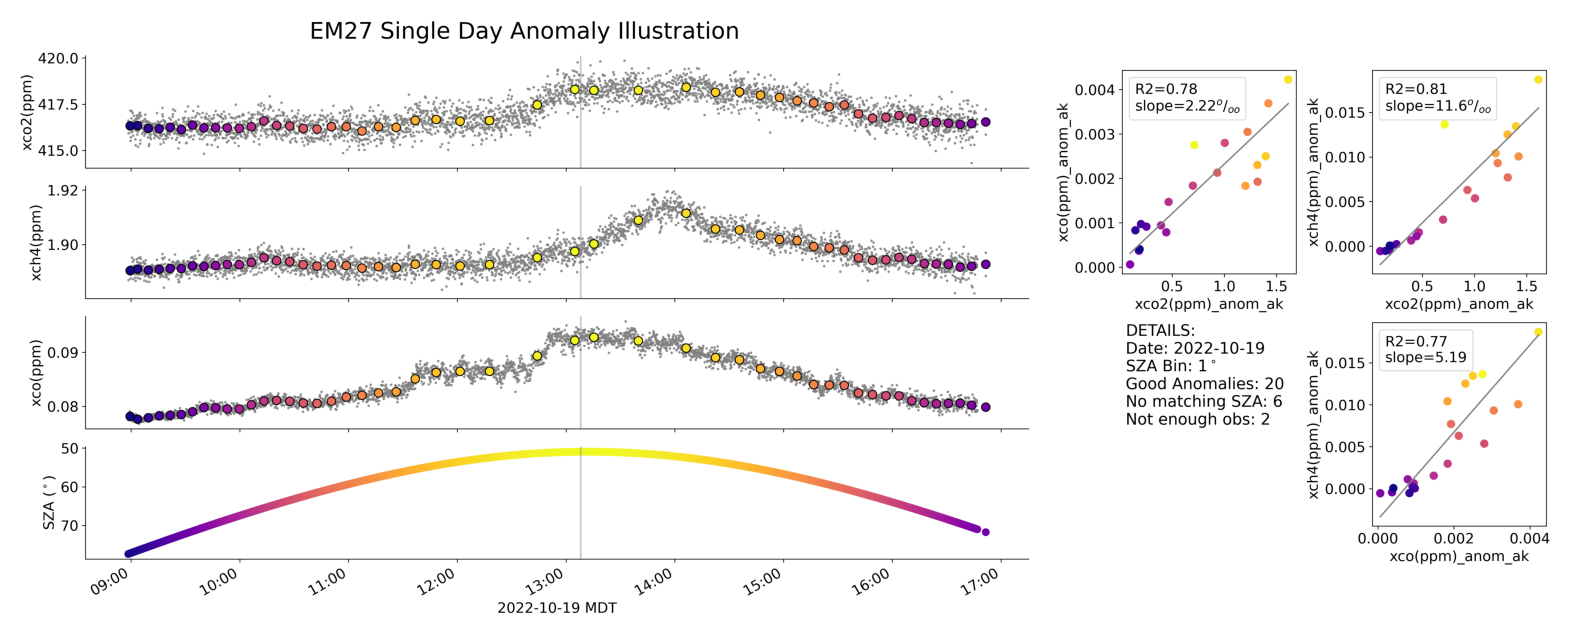

In [63]:
#Display the above plots side by side
fig = plt.figure(figsize = (20,10))
gs = gridspec.GridSpec(1,2,width_ratios=[2,1])

ax1 = plt.subplot(gs[0])
ax1.imshow(plt.imread(ts_fname))
ax1.axis('off')

ax2 = plt.subplot(gs[1])
ax2.imshow(plt.imread(ratio_fname))
ax2.axis('off')

plt.subplots_adjust(wspace=0.01)  # Adjust the wspace value as needed

plt.show()

## Anomoly Method: Full Dataset Ratios

In [68]:
#Define the datasets
anom_plot_df = all_anom_df.copy()
skipped_plot_df = all_skipped_df.copy()
#below is a quick filter for the extreme outliers found on 2023-08-09, the big spike day. They make the ratio plots look bad...
anom_plot_df = anom_plot_df.loc[anom_plot_df['date']!=datetime.date(2023,8,9)] 


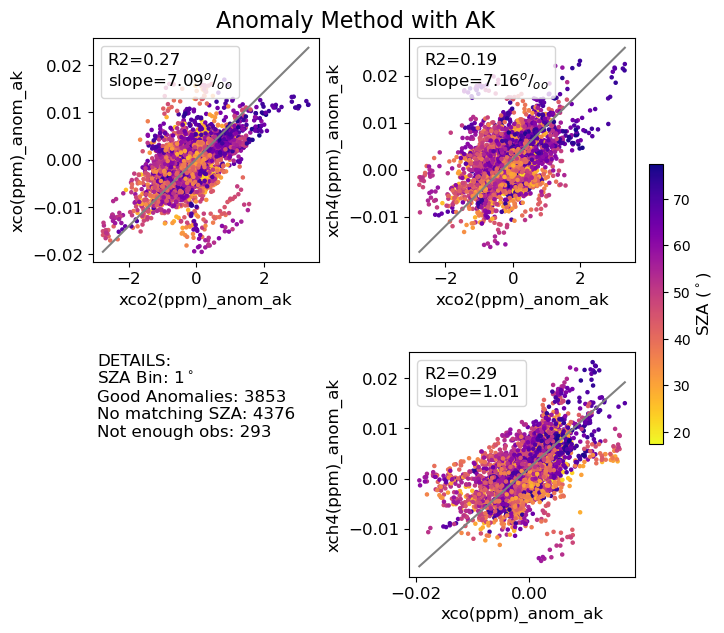

In [100]:
#Ratio plots for anomaly method

fig,axs = plt.subplots(2,2,figsize = (7,7))
labsize = 12
markersize = 5
fig.suptitle('Anomaly Method with AK',fontsize = 16,y=0.92)
fname = 'em27_allwbb_anomratio.png'

colorby_col = 'sza_mid'
cmap = 'plasma_r'


ax = axs[0,0]
x_spec = 'xco2(ppm)_anom_ak'
y_spec = 'xco(ppm)_anom_ak'
ax,sm = single_regression_subplot(ax,anom_plot_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=True)

ax = axs[0,1]
x_spec = 'xco2(ppm)_anom_ak'
y_spec = 'xch4(ppm)_anom_ak'
ax,sm = single_regression_subplot(ax,anom_plot_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=True)

ax = axs[1,1]
x_spec = 'xco(ppm)_anom_ak'
y_spec = 'xch4(ppm)_anom_ak'
ax,sm = single_regression_subplot(ax,anom_plot_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize)

axs[1,0].axis('off')
text = f"DETAILS:\n\
SZA Bin: {sza_bin_size}$^\circ$\n\
Good Anomalies: {len(anom_plot_df)}\n\
No matching SZA: {len(skipped_plot_df.loc[skipped_plot_df['skipmode']=='no_match_sza'])}\n\
Not enough obs: {len(skipped_plot_df.loc[skipped_plot_df['skipmode']=='nobs'])}"
axs[1,0].text(0.02,0.995,text,ha='left',va='top',fontsize = labsize)

# Creating the colorbar
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('SZA ($^\circ$)', fontsize=labsize)

plt.subplots_adjust(hspace=0.4,wspace = 0.4)
anom_fname = os.path.join(figures_path,fname)
#plt.savefig(anom_fname,dpi = 300,bbox_inches = 'tight')
#plt.close()
plt.show()


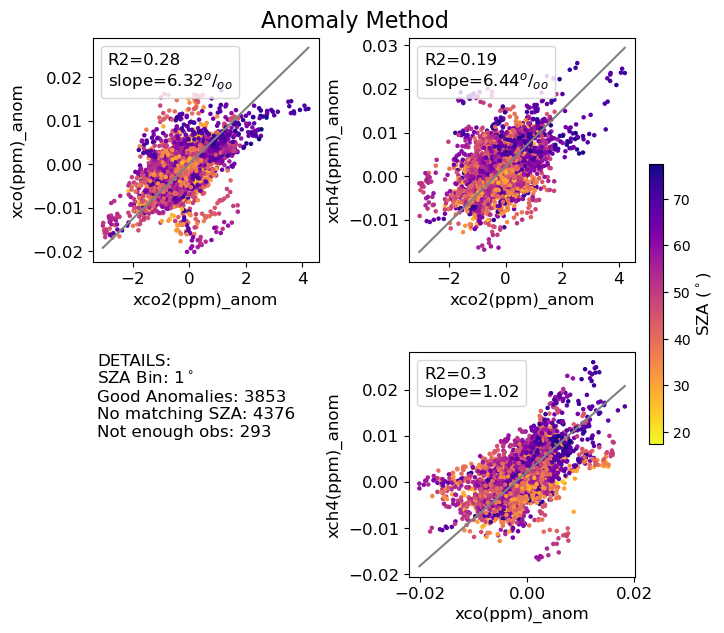

In [70]:
#Ratio plots for anomaly method

fig,axs = plt.subplots(2,2,figsize = (7,7))
labsize = 12
markersize = 5
fig.suptitle('Anomaly Method',fontsize = 16,y=0.92)
fname = 'em27_allwbb_anomratio.png'

colorby_col = 'sza_mid'
cmap = 'plasma_r'


ax = axs[0,0]
x_spec = 'xco2(ppm)_anom'
y_spec = 'xco(ppm)_anom'
ax,sm = single_regression_subplot(ax,anom_plot_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=True)

ax = axs[0,1]
x_spec = 'xco2(ppm)_anom'
y_spec = 'xch4(ppm)_anom'
ax,sm = single_regression_subplot(ax,anom_plot_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=True)

ax = axs[1,1]
x_spec = 'xco(ppm)_anom'
y_spec = 'xch4(ppm)_anom'
ax,sm = single_regression_subplot(ax,anom_plot_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize)

axs[1,0].axis('off')
text = f"DETAILS:\n\
SZA Bin: {sza_bin_size}$^\circ$\n\
Good Anomalies: {len(anom_plot_df)}\n\
No matching SZA: {len(skipped_plot_df.loc[skipped_plot_df['skipmode']=='no_match_sza'])}\n\
Not enough obs: {len(skipped_plot_df.loc[skipped_plot_df['skipmode']=='nobs'])}"
axs[1,0].text(0.02,0.995,text,ha='left',va='top',fontsize = labsize)

# Creating the colorbar
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label('SZA ($^\circ$)', fontsize=labsize)

plt.subplots_adjust(hspace=0.4,wspace = 0.4)
anom_fname = os.path.join(figures_path,fname)
#plt.savefig(anom_fname,dpi = 300,bbox_inches = 'tight')
#plt.close()
plt.show()



## Anomoly split by season

In [72]:
# Define the season plot
def season_anom_plot(anom_seasons_dict,x_spec,y_spec,permil):
    cmap = 'plasma_r'
    colorby_col = 'sza_mid'
    fig,axs = plt.subplots(2,2,figsize = (8,8))
    labsize = 12
    markersize = 5
    #fig.suptitle('Anomaly Method',fontsize = 16,y=0.92)

    season = 'DJF'
    ax = axs[0,0]
    ax.set_title(season,fontsize = labsize)
    plotdf = anom_seasons_dict[season]
    ax,sm = single_regression_subplot(ax,plotdf,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=permil)

    season = 'MAM'
    ax = axs[0,1]
    ax.set_title(season,fontsize = labsize)
    plotdf = anom_seasons_dict[season]
    ax,sm = single_regression_subplot(ax,plotdf,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=permil)

    season = 'JJA'
    ax = axs[1,0]
    ax.set_title(season,fontsize = labsize)
    plotdf = anom_seasons_dict[season]
    ax,sm = single_regression_subplot(ax,plotdf,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=permil)

    season = 'SON'
    ax = axs[1,1]
    ax.set_title(season,fontsize = labsize)
    plotdf = anom_seasons_dict[season]
    ax,sm = single_regression_subplot(ax,plotdf,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=permil)

    # Creating the colorbar
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_label('SZA ($^\circ$)', fontsize=labsize)

    plt.subplots_adjust(hspace=0.5,wspace = 0.7)
    anom_fname = os.path.join(figures_path,fname)
    #plt.savefig(anom_fname,dpi = 300,bbox_inches = 'tight')
    #plt.close()
    plt.show()

In [73]:
# Split into seasons
anom_seasons = split_seasons(anom_plot_df)

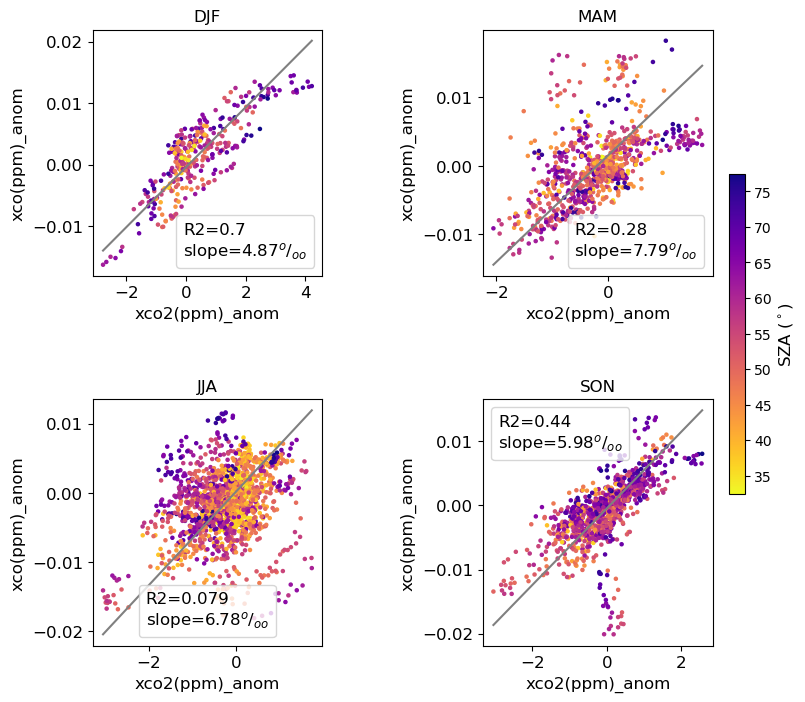

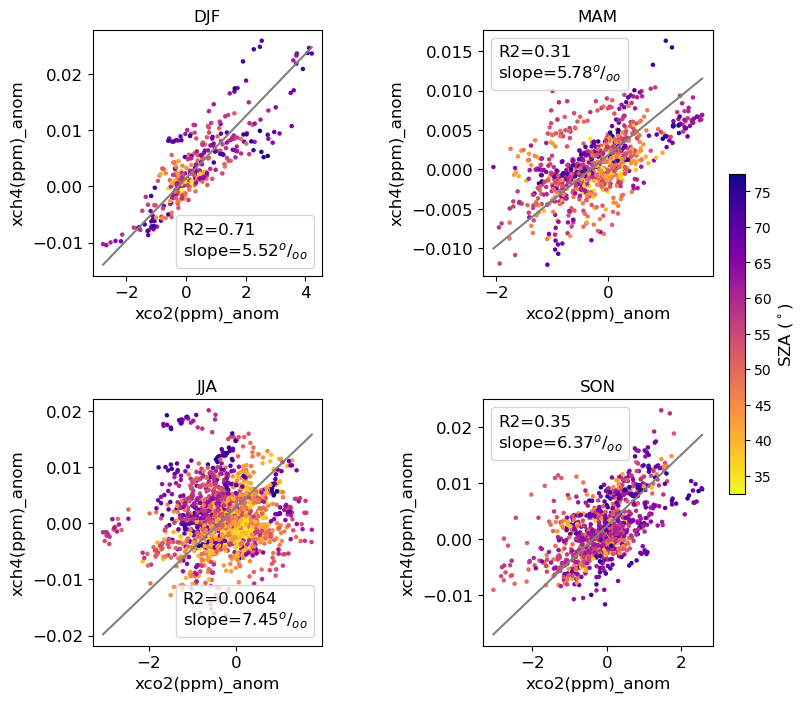

In [75]:
# Plot each ratio for all seasons
x_spec = 'xco2(ppm)_anom'
y_spec = 'xco(ppm)_anom'
season_anom_plot(anom_seasons,x_spec,y_spec,permil = True)

x_spec = 'xco2(ppm)_anom'
y_spec = 'xch4(ppm)_anom'
season_anom_plot(anom_seasons,x_spec,y_spec,permil = True)

# x_spec = 'xco(ppm)_anom'
# y_spec = 'xch4(ppm)_anom'
# season_anom_plot(anom_seasons,x_spec,y_spec,permil =False)

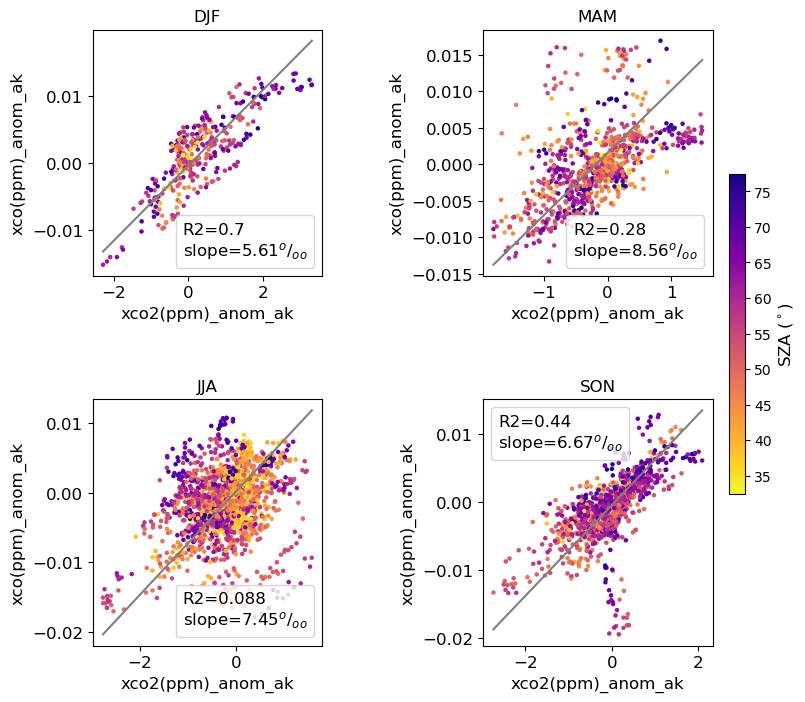

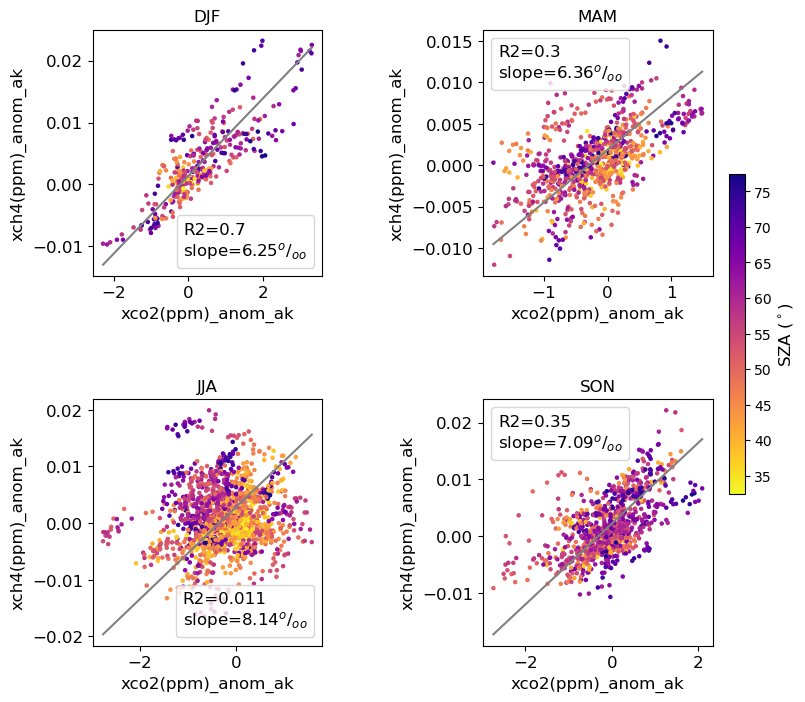

In [76]:
# Plot each ratio for all seasons
x_spec = 'xco2(ppm)_anom_ak'
y_spec = 'xco(ppm)_anom_ak'
season_anom_plot(anom_seasons,x_spec,y_spec,permil = True)

x_spec = 'xco2(ppm)_anom_ak'
y_spec = 'xch4(ppm)_anom_ak'
season_anom_plot(anom_seasons,x_spec,y_spec,permil = True)

# x_spec = 'xco(ppm)_anom'
# y_spec = 'xch4(ppm)_anom'
# season_anom_plot(anom_seasons,x_spec,y_spec,permil =False)

## Anomoly method weekday/weekend

In [ ]:
# Define the season plot
def wkdywkdn_anom_plot(anom_wkdy_wknd,x_spec,y_spec,permil):
    cmap = 'plasma_r'
    colorby_col = 'sza_mid'
    fig,axs = plt.subplots(1,2,figsize = (15,5))
    labsize = 12
    markersize = 5
    #fig.suptitle('Anomaly Method',fontsize = 16,y=0.92)

    wkdy_wknd = 'weekday'
    ax = axs[0]
    ax.set_title(wkdy_wknd,fontsize = labsize)
    plotdf = anom_wkdy_wknd[wkdy_wknd]
    ax,sm = single_regression_subplot(ax,plotdf,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=permil)

    wkdy_wknd = 'weekend'
    ax = axs[1]
    ax.set_title(wkdy_wknd,fontsize = labsize)
    plotdf = anom_wkdy_wknd[wkdy_wknd]
    ax,sm = single_regression_subplot(ax,plotdf,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=permil)

    # Creating the colorbar
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_label('SZA ($^\circ$)', fontsize=labsize)

    plt.subplots_adjust(hspace=0.5,wspace = 0.7)
    anom_fname = os.path.join(figures_path,fname)
    #plt.savefig(anom_fname,dpi = 300,bbox_inches = 'tight')
    #plt.close()
    plt.show()

In [ ]:
anom_wkdy_wknd = split_wkdy(anom_plot_df)

In [ ]:
# Plot each ratio for all seasons
x_spec = 'xco2(ppm)_anom'
y_spec = 'xco(ppm)_anom'
wkdywkdn_anom_plot(anom_wkdy_wknd,x_spec,y_spec,permil = True)

x_spec = 'xco2(ppm)_anom'
y_spec = 'xch4(ppm)_anom'
wkdywkdn_anom_plot(anom_wkdy_wknd,x_spec,y_spec,permil = True)

x_spec = 'xco(ppm)_anom'
y_spec = 'xch4(ppm)_anom'
wkdywkdn_anom_plot(anom_wkdy_wknd,x_spec,y_spec,permil =False)


# Daily Excess Using Concentration Quantiles

In [77]:
# Define functions needed for quantile method
def resample_and_get_excess(df,resample,col_list,quantile):
    out_df = df.copy()
    out_df = resample_df(out_df,resample)
    out_df = subtract_quantile(out_df,col_list,quantile)
    return out_df

def subtract_quantile(df,col_list,quantile):
    for col in col_list:
        df[quant_col_label(col,quantile)] = df[col] - get_col_quantile(df,col,quantile)
    return df

def quant_col_label(col,quantile):
    return f'{col}_ex{int(quantile*100)}q'

def get_col_quantile(df,col,quantile):
    return df[col].quantile(quantile)

def resample_df(df,resample):
    return df.resample(resample).mean(numeric_only = True).dropna(how='all')

def rmv_prep(str):
    return '_'.join(str.split('_')[1:])

def row_mult_ak_ratio(row,solzen_name,spec_name,num_ak_name,den_ak_name):
    ak_ratio = find_ak(ak_df[num_ak_name],row[solzen_name])/find_ak(ak_df[den_ak_name],row[solzen_name])
    return row[spec_name] * ak_ratio

In [93]:
# This creates all of the quantile dataframes, for each instrument across the entire dataset
# Once run, we have a dictionary called all_quantile_dfs, keys are inst_ids and values are all_quantile_df dataframes
# Each dataframe has the quantile subtracted concentration values along with the date that they came from 

resample = '5T'
quantile = 0.01
col_list = ['xco2(ppm)','xch4(ppm)','xco(ppm)']

all_quantile_df = pd.DataFrame() #initialize the quantile dataframe
for date_str, df in day_separated_dfs.items(): #for each day in the set of daily dataframes
    day_df = resample_and_get_excess(df,resample,col_list,quantile)
    day_df['hour_of_day'] = day_df.index.hour
    date = datetime.datetime.strptime(date_str,'%Y-%m-%d').date() #get the date
    day_df['date'] = date #add date columns to each of the dataframes
    all_quantile_df = pd.concat([all_quantile_df,day_df]) #concat with the previous date's dataframes
all_quantile_df = all_quantile_df.reset_index(drop=True) #reset the indicies for better viewing


In [95]:
all_quantile_df['xch4(ppm)_ex1q_ak'] = all_quantile_df.apply(lambda row: row_mult_ak_ratio(row,'solzen(deg)','xch4(ppm)_ex1q','co2','ch4'),axis = 1)
all_quantile_df['xco(ppm)_ex1q_ak'] = all_quantile_df.apply(lambda row: row_mult_ak_ratio(row,'solzen(deg)','xco(ppm)_ex1q','co2','co'),axis = 1)

## Quantile Method: Single Day

In [78]:
# Do quantile resampling
resample = '5T'
quantile = 0.01

date_str = '2022-10-19'
col_list = ['xco2(ppm)','xch4(ppm)','xco(ppm)']
day_df = day_separated_dfs[date_str].copy()
day_df = resample_and_get_excess(day_df,resample,col_list,quantile)
day_df['hour_of_day'] = day_df.index.hour

In [89]:
day_df['xch4(ppm)_ex1q_ak'] = day_df.apply(lambda row: row_mult_ak_ratio(row,'solzen(deg)','xch4(ppm)_ex1q','co2','ch4'),axis = 1)
day_df['xco(ppm)_ex1q_ak'] = day_df.apply(lambda row: row_mult_ak_ratio(row,'solzen(deg)','xco(ppm)_ex1q','co2','co'),axis = 1)

In [ ]:
#Create a timeseries plot showing each species of interest and the idea behind quantile backgroudn calculation
specs = ['xco2(ppm)','xch4(ppm)','xco(ppm)']

#Setup the fig
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
labsize = 16
markersize = 30
fig.suptitle('EM27 Daily Excess (Quantile) Illustration 5 minute mean resample', fontsize=24)
fname = 'em27_singleday_quantile_ts.png'

axs2 = []
for row in range(0,3):
    spec = specs[row] #get the species
    q_val = get_col_quantile(day_df,spec,quantile)
    axs[row].scatter(
        day_df.index,
        day_df[spec],
        s=markersize,
        c='grey',
        #alpha=0.8,
    ) #plot the raw data in grey on the left axis
    axs[row].axhline(q_val,
                     c = 'red',
                     label = f'Quantile {quantile}')
    axs[row].set_ylabel(rmv_prep(spec),size = labsize)
    axs[row].tick_params(labelsize=labsize)

    #plot the secondary axis with the excess data.
    axs2.append(axs[row].twinx())
    excess_col = quant_col_label(spec,quantile)
    axs2[row].scatter(
        day_df.index,
        day_df[excess_col],
        s=markersize,
        c='grey',
    ) #plot the excess data from the quantile on the right axis 
    axs2[row].set_ylabel(rmv_prep(excess_col),size = labsize)
    axs2[row].tick_params(labelsize=labsize)

    axs[row].spines['top'].set_visible(False)
    axs2[row].spines['top'].set_visible(False)

axs[0].legend(fontsize = labsize)
row = 2
axs[row].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=day_df.index.tz))
axs[row].set_xlabel(datetime.datetime.strftime(day_df.index[0], '%Y-%m-%d %Z'), size=labsize)

# Adjusting layout and formatting
plt.subplots_adjust(hspace=0.1)
plt.gcf().autofmt_xdate()
plt.tight_layout()
ts_fname = os.path.join(figures_path,fname)
plt.savefig(ts_fname,dpi = 300)
plt.close()
plt.show()

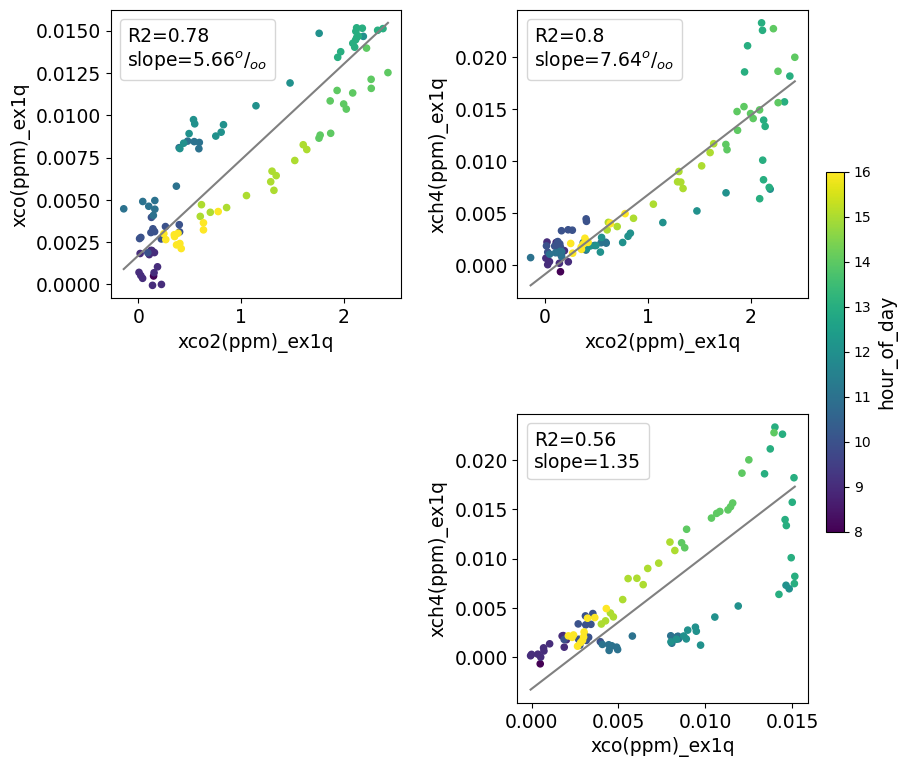

In [91]:
#Make the ratio plots, except this time color by the instrument to compare. Red is ua (DBK), blue is ha (WBB)

fig,axs = plt.subplots(2,2,figsize = (9,9))
labsize = 13.5
markersize = 20
#fig.suptitle('Ratios Using Daily Excess',fontsize = 12)
fname = 'em27_singleday_quantile_ratio.png'

colorby_col = 'hour_of_day'
cmap = 'viridis'

ax = axs[0,0]
x_spec = quant_col_label('xco2(ppm)',quantile)
y_spec = quant_col_label('xco(ppm)',quantile)
ax,sm = single_regression_subplot(ax,day_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil = True)

ax = axs[0,1]
x_spec = quant_col_label('xco2(ppm)',quantile)
y_spec = quant_col_label('xch4(ppm)',quantile)
ax,sm = single_regression_subplot(ax,day_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil = True)

ax = axs[1,1]
x_spec = quant_col_label('xco(ppm)',quantile)
y_spec = quant_col_label('xch4(ppm)',quantile)
ax,sm = single_regression_subplot(ax,day_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil = False)


cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label(colorby_col, fontsize=labsize)

axs[1,0].axis('off')

plt.subplots_adjust(hspace=0.4,wspace = 0.4)

ratio_fname = os.path.join(figures_path,fname)
#plt.savefig(ratio_fname,dpi = 300,bbox_inches = 'tight')
#plt.close()
plt.show()

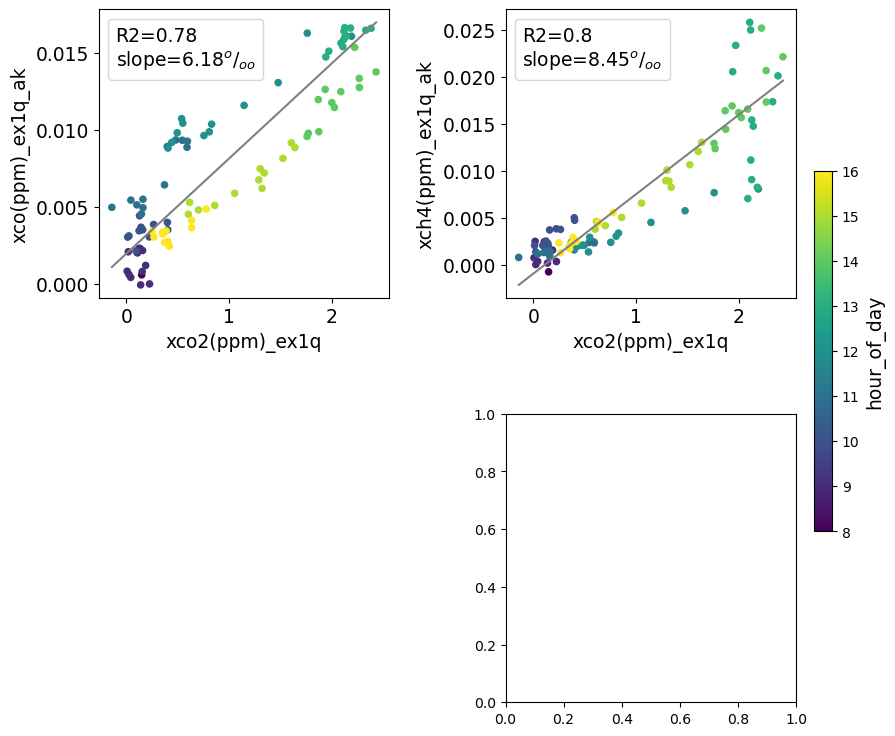

In [92]:
#Make the ratio plots, except this time color by the instrument to compare. Red is ua (DBK), blue is ha (WBB)

fig,axs = plt.subplots(2,2,figsize = (9,9))
labsize = 13.5
markersize = 20
#fig.suptitle('Ratios Using Daily Excess',fontsize = 12)
fname = 'em27_singleday_quantile_ratio.png'

colorby_col = 'hour_of_day'
cmap = 'viridis'

ax = axs[0,0]
x_spec = quant_col_label('xco2(ppm)',quantile)
y_spec = quant_col_label('xco(ppm)',quantile)+'_ak'
ax,sm = single_regression_subplot(ax,day_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil = True)

ax = axs[0,1]
x_spec = quant_col_label('xco2(ppm)',quantile)
y_spec = quant_col_label('xch4(ppm)',quantile)+'_ak'
ax,sm = single_regression_subplot(ax,day_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil = True)

# ax = axs[1,1]
# x_spec = quant_col_label('xco(ppm)',quantile)
# y_spec = quant_col_label('xch4(ppm)',quantile)
# ax,sm = single_regression_subplot(ax,day_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil = False)


cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label(colorby_col, fontsize=labsize)

axs[1,0].axis('off')

plt.subplots_adjust(hspace=0.4,wspace = 0.4)

ratio_fname = os.path.join(figures_path,fname)
#plt.savefig(ratio_fname,dpi = 300,bbox_inches = 'tight')
#plt.close()
plt.show()

In [ ]:
#Display the above plots side by side
fig = plt.figure(figsize = (20,10))
gs = gridspec.GridSpec(1,2,width_ratios=[1.5,1])

ax1 = plt.subplot(gs[0])
ax1.imshow(plt.imread(ts_fname))
ax1.axis('off')

ax2 = plt.subplot(gs[1])
ax2.imshow(plt.imread(ratio_fname))
ax2.axis('off')

plt.subplots_adjust(wspace=0.02)  # Adjust the wspace value as needed

plt.show()

## Quantile Method: Full Dataset Ratios

In [97]:
# Define the plot df
quantile_plot_df = all_quantile_df.copy()
#below is a quick filter for the extreme outliers found on 2023-08-09, the big spike day. They make the ratio plots look bad...
quantile_plot_df = quantile_plot_df.loc[quantile_plot_df['date']!=datetime.date(2023,8,9)]


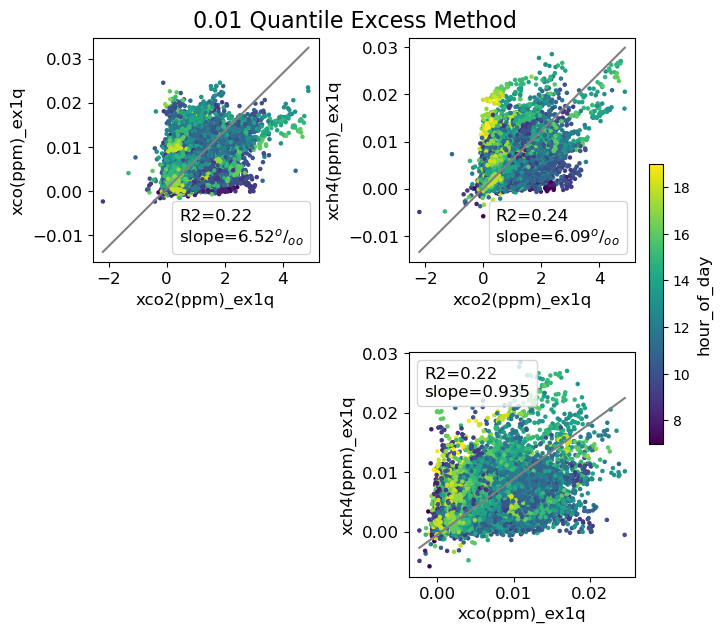

In [98]:
# Ratio plots for quantile method
fig,axs = plt.subplots(2,2,figsize = (7,7))
labsize = 12
markersize = 5
fig.suptitle(f'{quantile} Quantile Excess Method',fontsize = 16,y=0.92)

colorby_col = 'hour_of_day'
cmap = 'viridis'


ax = axs[0,0]
x_spec = quant_col_label('xco2(ppm)',quantile)
y_spec = quant_col_label('xco(ppm)',quantile)
ax,sm = single_regression_subplot(ax,quantile_plot_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=True)


ax = axs[0,1]
x_spec = quant_col_label('xco2(ppm)',quantile)
y_spec = quant_col_label('xch4(ppm)',quantile)
ax,sm = single_regression_subplot(ax,quantile_plot_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=True)


ax = axs[1,1]
x_spec = quant_col_label('xco(ppm)',quantile)
y_spec = quant_col_label('xch4(ppm)',quantile)
ax,sm = single_regression_subplot(ax,quantile_plot_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=False)

axs[1,0].axis('off')

cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label(colorby_col, fontsize=labsize)

plt.subplots_adjust(hspace=0.4,wspace = 0.4)
plt.show()



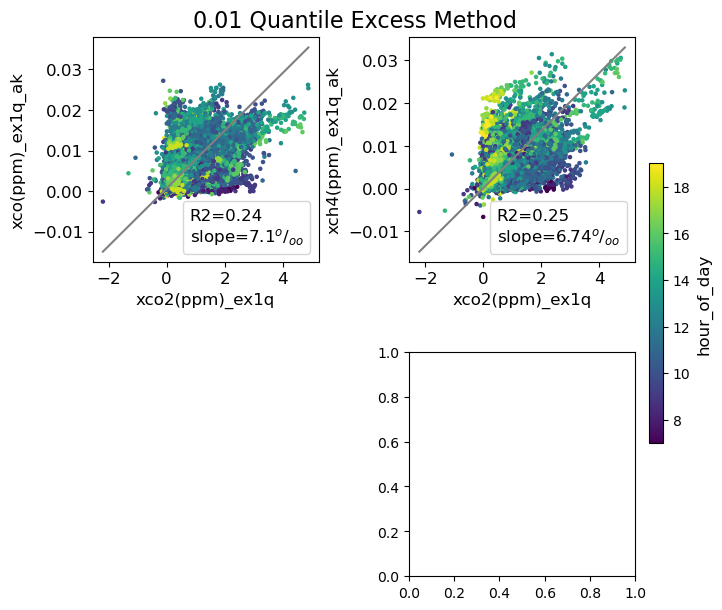

In [99]:
# Ratio plots for quantile method
fig,axs = plt.subplots(2,2,figsize = (7,7))
labsize = 12
markersize = 5
fig.suptitle(f'{quantile} Quantile Excess Method',fontsize = 16,y=0.92)

colorby_col = 'hour_of_day'
cmap = 'viridis'


ax = axs[0,0]
x_spec = quant_col_label('xco2(ppm)',quantile)
y_spec = quant_col_label('xco(ppm)',quantile)+'_ak'
ax,sm = single_regression_subplot(ax,quantile_plot_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=True)


ax = axs[0,1]
x_spec = quant_col_label('xco2(ppm)',quantile)
y_spec = quant_col_label('xch4(ppm)',quantile)+'_ak'
ax,sm = single_regression_subplot(ax,quantile_plot_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=True)


# ax = axs[1,1]
# x_spec = quant_col_label('xco(ppm)',quantile)
# y_spec = quant_col_label('xch4(ppm)',quantile)
# ax,sm = single_regression_subplot(ax,quantile_plot_df,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=False)

axs[1,0].axis('off')

cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
cbar = plt.colorbar(sm, cax=cbar_ax)
cbar.set_label(colorby_col, fontsize=labsize)

plt.subplots_adjust(hspace=0.4,wspace = 0.4)
plt.show()



## Quantile seasons

In [101]:
# Define the season plot
def season_quantile_plot(quantile_seasons_dict,x_spec,y_spec,permil):
    cmap = 'viridis'
    colorby_col = 'hour_of_day'
    fig,axs = plt.subplots(2,2,figsize = (8,8))
    labsize = 12
    markersize = 5

    season = 'DJF'
    ax = axs[0,0]
    ax.set_title(season,fontsize = labsize)
    plotdf = quantile_seasons_dict[season]
    ax,sm = single_regression_subplot(ax,plotdf,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil = permil)

    season = 'MAM'
    ax = axs[0,1]
    ax.set_title(season,fontsize = labsize)
    plotdf = quantile_seasons_dict[season]
    ax,sm = single_regression_subplot(ax,plotdf,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil = permil)

    season = 'JJA'
    ax = axs[1,0]
    ax.set_title(season,fontsize = labsize)
    plotdf = quantile_seasons_dict[season]
    ax,sm = single_regression_subplot(ax,plotdf,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil = permil)

    season = 'SON'
    ax = axs[1,1]
    ax.set_title(season,fontsize = labsize)
    plotdf = quantile_seasons_dict[season]
    ax,sm = single_regression_subplot(ax,plotdf,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil = permil)

    # Creating the colorbar
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Hour of Day', fontsize=labsize)

    plt.subplots_adjust(hspace=0.5,wspace = 0.7)
    plt.show()

In [102]:
# Split into seasons
quantile_seasons = split_seasons(quantile_plot_df)

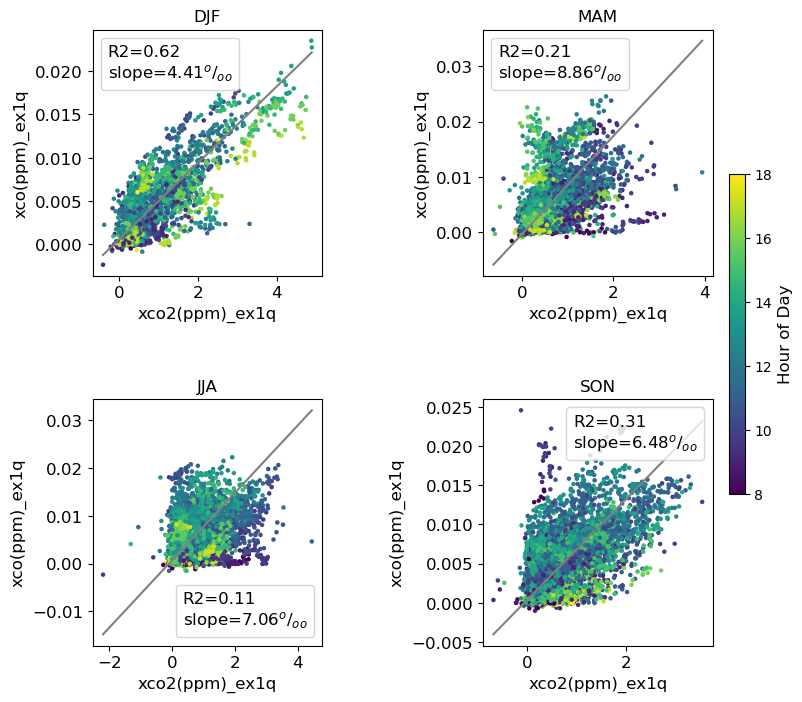

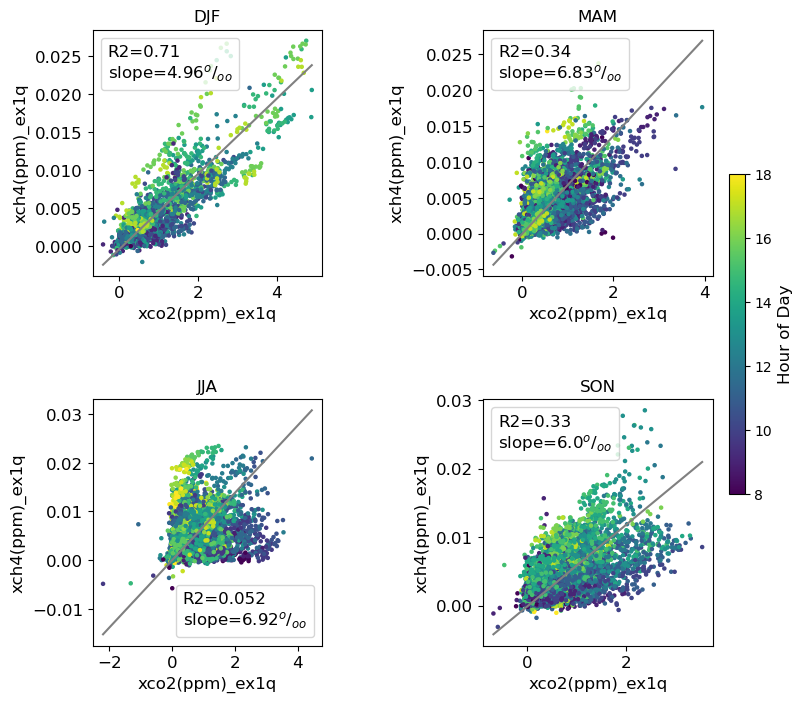

In [106]:
# Plot each ratio for all seasons
x_spec = quant_col_label('xco2(ppm)',quantile)
y_spec = quant_col_label('xco(ppm)',quantile)
season_quantile_plot(quantile_seasons,x_spec,y_spec,permil = True)

x_spec = quant_col_label('xco2(ppm)',quantile)
y_spec = quant_col_label('xch4(ppm)',quantile)
season_quantile_plot(quantile_seasons,x_spec,y_spec,permil = True)

# x_spec = quant_col_label('xco(ppm)',quantile)
# y_spec = quant_col_label('xch4(ppm)',quantile)
# season_quantile_plot(quantile_seasons,x_spec,y_spec,permil =False)

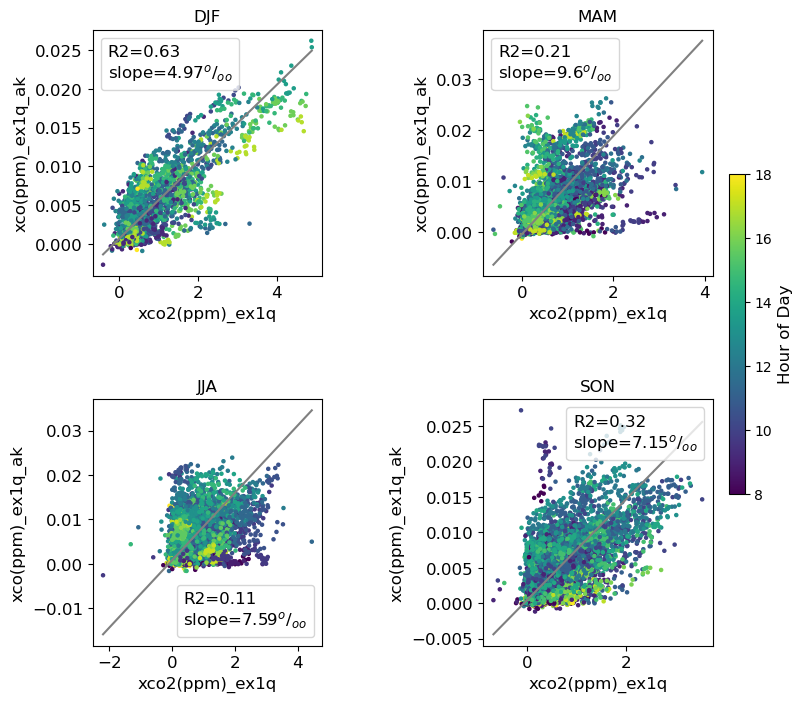

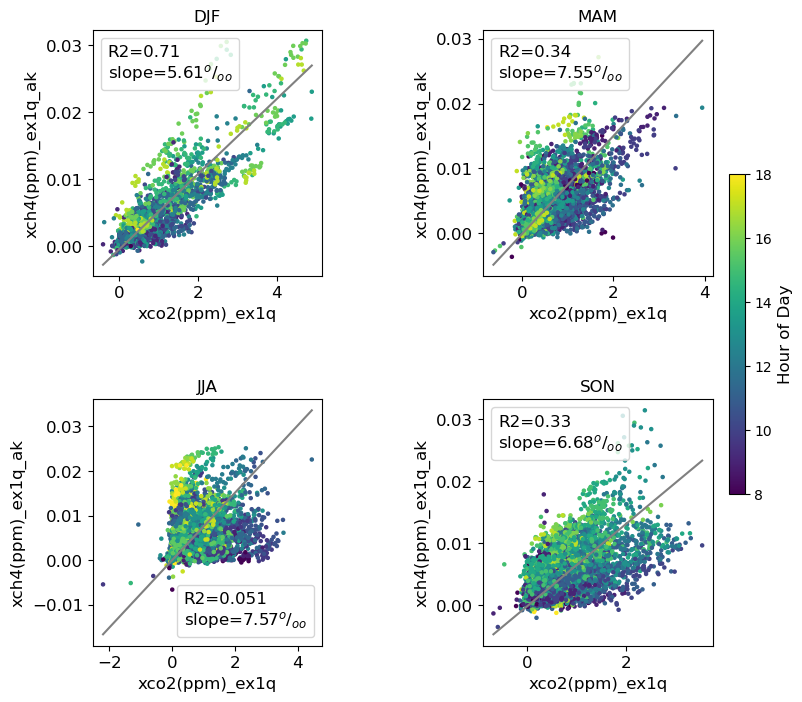

In [105]:
# Plot each ratio for all seasons
x_spec = quant_col_label('xco2(ppm)',quantile)
y_spec = quant_col_label('xco(ppm)',quantile)+'_ak'
season_quantile_plot(quantile_seasons,x_spec,y_spec,permil = True)

x_spec = quant_col_label('xco2(ppm)',quantile)
y_spec = quant_col_label('xch4(ppm)',quantile)+'_ak'
season_quantile_plot(quantile_seasons,x_spec,y_spec,permil = True)

# x_spec = quant_col_label('xco(ppm)',quantile)
# y_spec = quant_col_label('xch4(ppm)',quantile)
# season_quantile_plot(quantile_seasons,x_spec,y_spec,permil =False)

## Quantile weekday weekend

In [ ]:
# Define the season plot
def wkdywkdn_quantile_plot(quantile_wkdy_wknd,x_spec,y_spec,permil):
    cmap = 'viridis'
    colorby_col = 'hour_of_day'
    fig,axs = plt.subplots(1,2,figsize = (15,5))
    labsize = 12
    markersize = 5
    #fig.suptitle('Anomaly Method',fontsize = 16,y=0.92)

    wkdy_wknd = 'weekday'
    ax = axs[0]
    ax.set_title(wkdy_wknd,fontsize = labsize)
    plotdf = quantile_wkdy_wknd[wkdy_wknd]
    ax,sm = single_regression_subplot(ax,plotdf,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=permil)

    wkdy_wknd = 'weekend'
    ax = axs[1]
    ax.set_title(wkdy_wknd,fontsize = labsize)
    plotdf = quantile_wkdy_wknd[wkdy_wknd]
    ax,sm = single_regression_subplot(ax,plotdf,x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=permil)

    # Creating the colorbar
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Adjust position and size of colorbar
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Hour of Day', fontsize=labsize)

    plt.subplots_adjust(hspace=0.5,wspace = 0.7)
    anom_fname = os.path.join(figures_path,fname)
    #plt.savefig(anom_fname,dpi = 300,bbox_inches = 'tight')
    #plt.close()
    plt.show()

In [ ]:
quantile_wkdy_wknd = split_wkdy(quantile_plot_df)

In [ ]:
# Plot each ratio for all seasons
x_spec = quant_col_label('xco2(ppm)',quantile)
y_spec = quant_col_label('xco(ppm)',quantile)
wkdywkdn_quantile_plot(quantile_wkdy_wknd,x_spec,y_spec,permil = True)

x_spec = quant_col_label('xco2(ppm)',quantile)
y_spec = quant_col_label('xch4(ppm)',quantile)
wkdywkdn_quantile_plot(quantile_wkdy_wknd,x_spec,y_spec,permil = True)

x_spec = quant_col_label('xco(ppm)',quantile)
y_spec = quant_col_label('xch4(ppm)',quantile)
wkdywkdn_quantile_plot(quantile_wkdy_wknd,x_spec,y_spec,permil =False)




# Rolling Ratios and Mega Plot

In [ ]:
# Define rolling ratio functions

def rolling_regression_creator(regr_params,day_dfs):
    rolling_window_tdelt = pd.to_timedelta(regr_params['rolling_window']) #make the rolling window a timedelta to apply it to a datetime
    regr_day_details = {'regr_params':regr_params,'regr_results':{key: {} for key in regr_params['regr_labels']}} #create a dictionary to store both the parameters as well as the results of each regression
    resampled_oof_regr = day_dfs['resampled_oof'].copy() #copy the resampled day dataframe
    for regr_label,xy in regr_params['regr_labels'].items(): #loop through the regression name dictionary
        x_var = xy['x_var'] #setup the regression variables
        y_var = xy['y_var'] 
        regression_dicts = [] #where data from regressions will go
        for i in range(len(resampled_oof_regr)): #loop through rows of the day's dictionary -- we're finding windows around each of the datetimes in the dataframe
            dt = resampled_oof_regr.iloc[i].name #get the date of the current row

            #Get the df in the window defined by the rolling window parameter: We want the ratio of the values coming BEFORE the current datetime -- the value is the ratio of the values for the period dt - tdelt
            if (dt < resampled_oof_regr.iloc[0].name + rolling_window_tdelt): #cant get a ratio for the window at the beginning of the day because the window is not wide enough yet (dt - tdelt is less than the start of the df)
                regression_dicts.append(dict(dt = dt,slope=np.nan,r2=np.nan,nobs=np.nan)) #in this case, just return nans
                continue #and go on to the next row
            
            #Otherwise, get the window before the current datetime
            df_window = resampled_oof_regr.loc[(resampled_oof_regr.index > dt-rolling_window_tdelt)&(resampled_oof_regr.index <= dt)] 
            if len(df_window)>2: #don't want to do a regression on a window where there are only 2 observations
                regr_output = get_regression(df_window,dt,x_var,y_var) #if there are more that 2 observations, get the regression
            else:
                regr_output = dict(dt = dt,slope=np.nan,r2=np.nan,nobs=np.nan)
            regression_dicts.append(regr_output) #append the regression results to the list for use later

        regression_df = pd.DataFrame(regression_dicts).set_index('dt') #create a dataframe from the regression
        for col in regression_df.columns: 
            regression_df = regression_df.rename(columns={col:f'{regr_label}_{col}'}) #rename the columns to discern between the regression labels
        resampled_oof_regr = pd.concat([resampled_oof_regr,regression_df],axis = 1) #add the regression dataframe columns to the day's dataframe

        good_ratio_subdf = thresh_ratio_df(resampled_oof_regr,regr_label,regr_params) #get a subdataframe of the good regressions #get a subdataframe of the good regressions
        grouped_periods = find_grouped_periods(good_ratio_subdf,regr_params) #find the grouped periods for the good ratios 

        keep_cols = []
        for col in resampled_oof_regr.columns:
            if col.split('_')[0:2] == regr_label.split('_'):
                keep_cols.append(col)
        regr_df = resampled_oof_regr[keep_cols] #get the regression dataframe so we can return it
        regr_df['good'] = regr_df.index.isin(good_ratio_subdf.index) #add a column telling if each row is "good" or not based on the input params

        #append the results
        regr_day_details['regr_results'][regr_label] = dict(regr_df = regr_df,
                                                            grouped_periods = grouped_periods,
                                                            tot_ratios=len(resampled_oof_regr.dropna()),
                                                            good_ratios = len(good_ratio_subdf),
                                                            slope_mean = good_ratio_subdf[f'{regr_label}_slope'].mean(),
                                                            slope_std = good_ratio_subdf[f'{regr_label}_slope'].std())
        
    return regr_day_details


def thresh_ratio_df(df,regr_label,regr_params):
    cols = [col for col in df.columns if regr_label in col] #find the columns that contain the regression lable
    ndf = df[cols] #get the subdf with the above columns

    #The mask is finding rows that have r2 values above the r2 threshold and number of observations in the regression above the nobs_thresh
    mask = (ndf[f'{regr_label}_r2']>regr_params['r2_thresh'])&(ndf[f'{regr_label}_nobs']>=regr_params['nobs_thresh']) 
    return ndf[mask]

def annotate_rr_sumaries(regr_day_results,regr_label,keys_to_include = ['tot_ratios','good_ratios','slope_mean','slope_std']):
    permil = regr_day_results['regr_params']['regr_labels'][regr_label]['permil']
    text = regr_label + '\n'
    for k,v in regr_day_results['regr_results'][regr_label].items():
        if k not in keys_to_include:
            continue
        if 'slope' in k:
            if permil:
                v = v*1000
            v = "{0:.3g}".format(v)
            if permil:
                v = v+"$^o/_{oo}$"
        text = f'{text} {k} = {v}\n'
    return text

def get_regression(df_window,dt,x_var,y_var):
    linregress_result = regress2(df_window[x_var],df_window[y_var])
    return dict(dt = dt,
                dt_range = [df_window.iloc[0].name,df_window.iloc[-1].name],
                slope=linregress_result['slope'],
                r2=linregress_result['r']**2,
                nobs=int(len(df_window)))

def find_grouped_periods(df,regr_params):
    deltas = df.index.diff() #create a column with the difference between rows
    dt_groups = [] #initialize a list of "groups"
    for i in range(len(df)): #loop through the rows
        dt = df.iloc[i].name #get the datetime
        delta = deltas[i] #get the difference between that row and the previous row
        if i == 0: #always get the first row
            dt_groups.append([dt]) #and append it to the group as a list
            continue
        if delta <= regr_params['grouped_tdelta_thresh']: #if the previous row is within the threshold for "within group"
            dt_groups[-1].append(dt) #append it to the most recently created group
        else:
            dt_groups.append([dt]) #otherwise, start a new group and append that datetime as a list

    grouped_periods = [] #initialize the grouped periods
    for dt_group in dt_groups: #loop through the groups
        if len(dt_group) >= regr_params['nratio_good_thresh']: #if there are more than the minimum number of "good" ratios in the group, 
            grouped_periods.append(dict(dt1 = dt_group[0],
                                            dt2 = dt_group[-1],
                                            n_good = len(dt_group))) #append it to the good grouped periods 
    return grouped_periods

def trim_df_by_dtidx(df,dt1,dt2):
    outdf = df.loc[(df.index>=dt1)&(df.index<=dt2)]
    return outdf

def resample_met_df(met_df,interval):
    outdf = met_df.copy()
    outdf = outdf[['pres','temp','rh','u','v']].resample(interval).mean(numeric_only = True)
    outdf['ws'],outdf['wd'] = np.vectorize(ac.uv_to_wdws)(outdf['u'],outdf['v'])
    return outdf

def resample_and_roll_met(met_df,resample,roll):
    met_df_resampled = resample_met_df(met_df,resample)
    rolling_df = met_df_resampled[['u','v']].rolling(roll,min_periods = 10).mean()
    rolling_df['ws_roll'],rolling_df['wd_roll'] = np.vectorize(ac.uv_to_wdws)(rolling_df['u'],rolling_df['v'])
    rolling_df = rolling_df[['wd_roll','ws_roll']]
    met_df_resampled = pd.concat([met_df_resampled,rolling_df],axis = 1)
    return met_df_resampled

def get_day_dfs(day_separated_dfs,wbb_day_separated_dfs,date_str,sza_bin_size,resample,species_names,quantile):
    #Setup the dataframes
    oof_df = day_separated_dfs[date_str].copy()  #get the specific day's df for that instrument

    #setup anomaly data
    binned_summary_df = create_binned_summary(oof_df,sza_bin_size,species_names) #create the binned summary 
    anom_day_df, skipped_df = daily_anomaly_creator(binned_summary_df,species_names) #get the anomaly and skipped rows dataframes 

    # Do quantile resampling
    resampled_day_df = resample_and_get_excess(oof_df,resample,species_names,quantile) #resample and get the excess values from teh quantile
    resampled_day_df['hour_of_day'] = resampled_day_df.index.hour #get the hour of the day for easy plotting coloring

    #Setup met data
    met_day_df = wbb_day_separated_dfs[date_str] 

    day_dfs = {'date_str':date_str,'oof':oof_df,'resampled_oof':resampled_day_df,'anom':anom_day_df,'binned_summary':binned_summary_df,'met':met_day_df,'quantile':quantile,'resample':resample}
    return day_dfs

In [ ]:
# Define helper functions for mega plot
def oof_ts_plot(day_dfs,ax,spec,extraplot='sza'):
    ax.scatter(
        day_dfs['oof'].index,
        day_dfs['oof'][spec],
        s=3,
        c='grey',
        alpha=0.8,
        label='Collected Data'
    ) #plot the raw data in grey 
    if extraplot == 'sza':
        color_col_min = day_dfs['binned_summary']['sza_mid'].min()
        color_col_max = day_dfs['binned_summary']['sza_mid'].max()
        cmap = 'plasma_r'
        # Create a ScalarMappable object for color mapping
        norm = Normalize(vmin=color_col_min, vmax=color_col_max)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # To satisfy 
        
        ax.scatter(
            day_dfs['binned_summary']['tmid'],
            day_dfs['binned_summary'][spec],
            s=80,
            edgecolors = 'k',
            c=day_dfs['binned_summary']['sza_mid'],
            cmap=cmap,
            norm=norm,  # Apply the same normalization to ensure consistent color scale
        )#plot the sza binned data, and color by like sza bins
        
    ax.tick_params(labelsize=labsize)
    ax.set_ylabel(spec, size=labsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvline(min_sza_idx, c='grey', alpha=0.5)
    for label in ax.get_xticklabels():
        label.set_visible(False)
    ax.set_xlabel('')
    #xlims = [(day_dfs['oof'].index.min() - datetime.timedelta(hours =1)),(day_dfs['oof'].index.max() + datetime.timedelta(hours = 1))]
    #ax.set_xlim(xlims)


def ratio_ts_plot(ax,day_dfs,regr_day_results,regr_label):
    regr_df = regr_day_results['regr_results'][regr_label]['regr_df']
    good_ratio_subdf = regr_df.loc[regr_df['good']]
    bad_ratio_subdf = regr_df.loc[~regr_df['good']]
    permil = regr_day_results['regr_params']['regr_labels'][regr_label]['permil']
    if permil:
        scatter = ax.scatter(
                good_ratio_subdf.index,
                good_ratio_subdf[f'{regr_label}_slope']*1000,
                s=50,
                c=good_ratio_subdf[f'{regr_label}_r2'],
                vmin=0,vmax=1,
                cmap = 'Greys',
                edgecolors = 'red'
            ) 
        scatter = ax.scatter(
                bad_ratio_subdf.index,
                bad_ratio_subdf[f'{regr_label}_slope']*1000,
                s=50,
                c=bad_ratio_subdf[f'{regr_label}_r2'],
                vmin=0,vmax=1,
                cmap = 'Greys',
                edgecolors='grey'
            ) 
    else:
        scatter = ax.scatter(
                good_ratio_subdf.index,
                good_ratio_subdf[f'{regr_label}_slope'],
                s=50,
                c=good_ratio_subdf[f'{regr_label}_r2'],
                vmin=0,vmax=1,
                cmap = 'Greys',
                edgecolors = 'red'
            ) 
        scatter = ax.scatter(
                bad_ratio_subdf.index,
                bad_ratio_subdf[f'{regr_label}_slope'],
                s=50,
                c=bad_ratio_subdf[f'{regr_label}_r2'],
                vmin=0,vmax=1,
                cmap = 'Greys',
                edgecolors='grey'
            ) 
        
    for period in regr_day_results['regr_results'][regr_label]['grouped_periods']:
        ax.axvspan(period['dt1'],period['dt2'],color = 'yellow',alpha = 0.3)
        window_df = trim_df_by_dtidx(regr_df,period['dt1'],period['dt2'])
        slope_mean = window_df[f'{regr_label}_slope'].mean()
        slope_std = window_df[f'{regr_label}_slope'].std()
        if permil:
            text = "{0:.3g}".format(slope_mean*1000) + "$^o/_{oo}$\n" +"+/-{0:.3g}".format(slope_std*1000)+"$^o/_{oo}$"
        else:
            text = '{0:.3g}\n+/-{1:.3g}'.format(slope_mean,slope_std)

        ymin,ymax = ax.get_ylim()
        ax.annotate(text,(period['dt1'],ymin),verticalalignment='bottom')

    ax.tick_params(labelsize=labsize)
    if permil:
        ax.set_ylabel(f'{regr_label}_slope'+"$^o/_{oo}$", size=labsize)
    else:
        ax.set_ylabel(f'{regr_label}_slope', size=labsize)
    ax.spines['top'].set_visible(False)
    for label in ax.get_xticklabels():
        label.set_visible(False)
    ax.set_xlabel('')
    #xlims = [(day_dfs['oof'].index.min() - datetime.timedelta(hours =1)),(day_dfs['oof'].index.max() + datetime.timedelta(hours = 1))]
    #ax.set_xlim(xlims)
    return scatter

def add_rr_summary_annotations(ax,regr_day_results,regr_label):
    text = annotate_rr_sumaries(regr_day_results,regr_label)
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator())
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator())
    ax.text(0.02,0.995,text,ha='left',va='top',fontsize = labsize*1.2)

In [ ]:
# Define mega plot
def mega_ratio_plot(day_dfs,regr_day_results,show = False):
    fig = plt.figure(figsize = (20,17))
    gs = gridspec.GridSpec(7,3,width_ratios=[3,1,1],height_ratios=[1,1,1,.9,.9,.9,0.8])
    labsize = 14

    #First column
    row = 0; col = 0
    ax = plt.subplot(gs[row,col])
    spec = 'xch4(ppm)'
    oof_ts_plot(day_dfs,ax,spec,extraplot='sza')

    row = 1; col = 0
    ax = plt.subplot(gs[row,col])
    spec = 'xco2(ppm)'
    oof_ts_plot(day_dfs,ax,spec,extraplot='sza')

    row = 2; col = 0
    ax = plt.subplot(gs[row,col])
    spec = 'xco(ppm)'
    oof_ts_plot(day_dfs,ax,spec,extraplot='sza')

    row = 3; col = 0
    ax = plt.subplot(gs[row,col])
    regr_label = 'ch4_co2'
    ratio_ts_plot(ax,day_dfs,regr_day_results,regr_label)
    col = 1
    ax = plt.subplot(gs[row,col])
    add_rr_summary_annotations(ax,regr_day_results,regr_label)

    row = 4; col = 0
    ax = plt.subplot(gs[row,col])
    regr_label = 'ch4_co'
    ratio_ts_plot(ax,day_dfs,regr_day_results,regr_label)
    col = 1
    ax = plt.subplot(gs[row,col])
    add_rr_summary_annotations(ax,regr_day_results,regr_label)

    row = 5; col = 0
    ax = plt.subplot(gs[row,col])
    regr_label = 'co_co2'
    scatter = ratio_ts_plot(ax,day_dfs,regr_day_results,regr_label)
    col = 1
    ax = plt.subplot(gs[row,col])
    add_rr_summary_annotations(ax,regr_day_results,regr_label)

    try:
        row = 6; col = 0
        ax = plt.subplot(gs[row,col])
        windmode = 5
        wind_cmap = matplotlib.colormaps['Blues']
        new_cmap = truncate_colormap(wind_cmap, 0.3, 1)
        ax.barbs(day_dfs['met'][::windmode].index,0,day_dfs['met']['u'][::windmode],day_dfs['met']['v'][::windmode],
                        day_dfs['met']['ws'][::windmode],cmap = new_cmap,length =7,linewidth = 2,barb_increments={'half':3,'full':5,'flag':10})
        ax.tick_params(labelsize = labsize)
        ax.set_ylabel('wind barbs',size = labsize)
        ax.get_yaxis().set_ticklabels([])
        ax.set_ylim(-1,1)
        ax.set_xlabel('')

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=day_dfs['met'].index.tz))
        ax.set_xlabel(datetime.datetime.strftime(day_dfs['met'].index[0], '%Y-%m-%d %Z'), size=labsize)
        for label in ax.get_xticklabels():
            label.set_ha('right')
            label.set_rotation(30.)
    except:
        pass

    for row in range(0,7):
        ax = plt.subplot(gs[row,col])
        xlims = [(day_dfs['oof'].index.min() - datetime.timedelta(hours =1)),(day_dfs['oof'].index.max() + datetime.timedelta(hours = 1))]
        ax.set_xlim(xlims)


    try:
        colorby_col = 'sza_mid'
        cmap = 'plasma_r'
        row = 0; col = 1
        ax = plt.subplot(gs[row,col])
        markersize = 50
        x_spec = 'xco2(ppm)_anom'
        y_spec = 'xch4(ppm)_anom'
        ax,sm = single_regression_subplot(ax,day_dfs['anom'],x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=True)

        row = 1; col = 1
        ax = plt.subplot(gs[row,col])
        x_spec = 'xco(ppm)_anom' 
        y_spec = 'xch4(ppm)_anom'
        ax,sm = single_regression_subplot(ax,day_dfs['anom'],x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=False)

        row = 2; col = 1
        ax = plt.subplot(gs[row,col])
        x_spec = 'xco2(ppm)_anom'
        y_spec = 'xco(ppm)_anom'
        ax,sm = single_regression_subplot(ax,day_dfs['anom'],x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=True)
        ax.tick_params(labelsize = labsize, which = 'both', axis = 'both')
    except:
        pass

    colorby_col = 'hour_of_day'
    cmap = 'viridis'
    quantile = day_dfs['quantile']
    row = 0; col = 2
    ax = plt.subplot(gs[row,col])
    x_spec = quant_col_label('xco2(ppm)',quantile)
    y_spec = quant_col_label('xch4(ppm)',quantile)
    ax,sm = single_regression_subplot(ax,day_dfs['resampled_oof'],x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=True)
    ax.set_xlabel(x_spec,size = labsize)
    ax.set_ylabel(y_spec,size = labsize)
    ax.tick_params(labelsize = labsize)

    row = 1; col = 2
    ax = plt.subplot(gs[row,col])
    x_spec = quant_col_label('xco(ppm)',quantile)
    y_spec = quant_col_label('xch4(ppm)',quantile)
    ax,sm = single_regression_subplot(ax,day_dfs['resampled_oof'],x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=False)
    # ax.set_xlabel(rmv_prep(x_spec),size = labsize)
    # ax.set_ylabel(rmv_prep(y_spec),size = labsize)
    ax.tick_params(labelsize = labsize)

    row = 2; col = 2
    ax = plt.subplot(gs[row,col])
    x_spec = quant_col_label('xco2(ppm)',quantile)
    y_spec = quant_col_label('xco(ppm)',quantile)
    ax,sm = single_regression_subplot(ax,day_dfs['resampled_oof'],x_spec,y_spec,colorby_col,markersize,cmap,labsize,slope_permil=True)
    # ax.set_xlabel(rmv_prep(x_spec),size = labsize)
    # ax.set_ylabel(rmv_prep(y_spec),size = labsize)
    ax.tick_params(labelsize = labsize)

    ax = plt.subplot(gs[3:6,2])
    cbar_ax = fig.add_axes([.82,0.25, .03, 0.3])  # Adjust position and size of colorbar
    cbar = plt.colorbar(scatter, cax=cbar_ax)
    cbar.set_label('Regression R2', fontsize=labsize)
    cbar.ax.tick_params(labelsize=labsize)
    ax.axis('off')

    ax = plt.subplot(gs[3,2])
    cbar_ax = fig.add_axes([.82,0.12, .16, 0.05])  # Adjust position and size of colorbar
    cbar = plt.colorbar(sm, cax=cbar_ax,orientation = 'horizontal')
    cbar.set_label(colorby_col, fontsize=labsize)
    ax.axis('off')

    try:
        row = 6; col = 1
        ax = plt.subplot(gs[row,col])
        wr_df = day_dfs['met'].copy()
        wr_df = wr_df[['ws','wd']]
        wr_df = wr_df.loc[(wr_df.index >= day_dfs['oof'].index.min())&(wr_df.index<=day_dfs['oof'].index.max())]
        rect = ax.get_position()
        bbox = np.array(rect)
        mult = 1
        bbox_0 = bbox[0]
        bbox_0[1] = 0.02
        bbox_h = (bbox[1,1]-bbox[0,1])*mult
        bbox_w = (bbox[1,0]-bbox[0,0])*mult
        wax = WindroseAxes(fig,matplotlib.transforms.Bbox.from_bounds(bbox_0[0],bbox_0[1],bbox_w,bbox_h))
        fig.add_axes(wax)
        wax.bar(wr_df['wd'],wr_df['ws'],cmap=matplotlib.cm.Blues)
        wax.set_xticklabels([])
        wax.set_yticklabels([])
        ax.axis('off')
        ax.text(0.7,0.15,f"WS_ave={round(wr_df['ws'].mean(),1)}",fontsize = 14)
    except:
        pass

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.18)  # Adjust the wspace value as needed

    if show:
        plt.show()
    else:
        plt.close()
    return fig

In [ ]:
#Example
resample = '5T' #the resample interval of the EM27 data
quantile = 0.01 #the lower quantile to use as the day's background
species_names = ['xco2(ppm)','xch4(ppm)','xco(ppm)']
sza_bin_size = 1

regr_params = {'regr_labels': {'ch4_co2':{'x_var':quant_col_label('xco2(ppm)',quantile),
                                           'y_var':quant_col_label('xch4(ppm)',quantile),
                                           'permil':True},
                                'co_co2': {'x_var':quant_col_label('xco2(ppm)',quantile),
                                           'y_var':quant_col_label('xco(ppm)',quantile),
                                           'permil':True},
                                'ch4_co': {'x_var':quant_col_label('xco(ppm)',quantile),
                                           'y_var':quant_col_label('xch4(ppm)',quantile),
                                           'permil':False},
                                        },    
                    'rolling_window' : '1H', # size of the rolling window
                    'r2_thresh' : 0.8, # minimum threshold for what defines a "good" r2 value in the window regression
                    'nobs_thresh' : 5, # minimum threshold for number of observations included in the window regression to be considered "good"
                    'grouped_tdelta_thresh' : pd.to_timedelta(resample)*2, # timedelta that says if two observations can be considered "grouped" 
                    'nratio_good_thresh' : 6 # minimum number of good ratios in a group for the group to be considered "good"            
                    }

date_str = '2022-09-10' #date string
day_dfs = get_day_dfs(day_separated_dfs,wbb_day_separated_dfs,date_str,sza_bin_size,resample,species_names,quantile)
regr_day_results = rolling_regression_creator(regr_params,day_dfs)
met_resampled = resample_and_roll_met(day_dfs['met'],'5T','2H')
#fig = mega_ratio_plot(day_dfs,regr_day_results,show = True)

## All rolling ratios 

In [ ]:
save = True
show = False

regr_params = {'regr_labels': {'ch4_co2':{'x_var':quant_col_label('xco2(ppm)',quantile),
                                           'y_var':quant_col_label('xch4(ppm)',quantile),
                                           'permil':True},
                                'co_co2': {'x_var':quant_col_label('xco2(ppm)',quantile),
                                           'y_var':quant_col_label('xco(ppm)',quantile),
                                           'permil':True},
                                'ch4_co': {'x_var':quant_col_label('xco(ppm)',quantile),
                                           'y_var':quant_col_label('xch4(ppm)',quantile),
                                           'permil':False},
                                        },    
                    'rolling_window' : '1H', # size of the rolling window
                    'r2_thresh' : 0.8, # minimum threshold for what defines a "good" r2 value in the window regression
                    'nobs_thresh' : 5, # minimum threshold for number of observations included in the window regression to be considered "good"
                    'grouped_tdelta_thresh' : pd.to_timedelta(resample)*2, # timedelta that says if two observations can be considered "grouped" 
                    'nratio_good_thresh' : 6 # minimum number of good ratios in a group for the group to be considered "good"            
                    }

good_grouped_periods_fulldfs = {}
for regr_label in regr_params['regr_labels'].keys(): 
    good_grouped_periods_fulldfs[regr_label] = pd.DataFrame()
regr_results = {}

for date_str in day_separated_dfs.keys():
    print(date_str)
    day_dfs = get_day_dfs(day_separated_dfs,wbb_day_separated_dfs,date_str,sza_bin_size,resample,species_names,quantile)
    regr_day_results = rolling_regression_creator(regr_params,day_dfs)
    met_resampled = resample_and_roll_met(day_dfs['met'],resample,'1H')
    for regr_label in regr_params['regr_labels'].keys():
        good_grouped_em27_regr = pd.DataFrame()
        good_grouped_met = pd.DataFrame()
        for grouped_period in regr_day_results['regr_results'][regr_label]['grouped_periods']:
            good_period_em27_regr = trim_df_by_dtidx(regr_day_results['regr_results'][regr_label]['regr_df'],grouped_period['dt1'],grouped_period['dt2'])
            good_grouped_em27_regr = pd.concat([good_grouped_em27_regr,good_period_em27_regr])
            if len(met_resampled)==0:
                continue
            good_period_met = trim_df_by_dtidx(met_resampled,grouped_period['dt1'],grouped_period['dt2'])
            good_grouped_met = pd.concat([good_grouped_met,good_period_met])
        good_grouped_merged = pd.concat([good_grouped_em27_regr,good_grouped_met],axis = 1)
        good_grouped_periods_fulldfs[regr_label] = pd.concat([good_grouped_periods_fulldfs[regr_label],good_grouped_merged])
    # fig = mega_ratio_plot(day_dfs,regr_day_results,show = show)
    # if save:
    #     fig.savefig(os.path.join(figures_path,'mega_ratio_plots',f"{day_dfs['date_str']}.png"))
    regr_results[date_str] = copy.deepcopy(regr_day_results)
    
#good_grouped_periods_fulldfs

In [ ]:
for regr_label in good_grouped_periods_fulldfs.keys():
    fname = f'202205-202404_{resample}_{regr_label}.csv'
    good_grouped_periods_fulldfs[regr_label].round(5).reset_index().dropna().to_csv(os.path.join(base_project_dir,'Data/csv_for_r/ratios_v3',fname),index=False)

In [ ]:
# # SAVING --careful not to overwrite
pickle_path = f'/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/Pickled_files/ratio_v3'

fname = 'good_grouped_periods_fulldfs.pkl'
with open(os.path.join(pickle_path,fname), 'wb') as handle:
    pickle.dump(good_grouped_periods_fulldfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

fname = 'full_regr_results.pkl'
with open(os.path.join(pickle_path,fname), 'wb') as handle:
    pickle.dump(regr_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Most interesting mega plots
2022-06-15     
2022-06-16      
2022-06-27      
2022-07-07 - South wind no ratios     
2022-07-26 - Shifts, nw wind with high ch4/co2 ratios        
2022-09-10 - Strong shift e to w        
2022-09-27 - n wind: lower CH4/CO2 ratios with north wind. Good co-co2 ratios matching inventory ratios              
2022-10-17 - strength shift     
2022-10-19 - strength, direction shift      
2022-10-20 - strength  
2022-02-13 - strength and direction shift. low wind = low ch4/co2, medium west = higher ch4/co2     
2023-03-17 - ne nw shift good illustration of wind shif good for co/co2 compared to inventory, but not for ch4/co2    
2023-05-19 - ne nw shift        
2023-07-28 - s n shift shoing ch4/co2 ratios changing with wind shifts -- higher from north     
2023-08-14 - ne sw shift        
2023-09-06 - s n shift      
2023-09-15 - strength shift     
2023-09-27 - s n shift      
2023-11-14 - ch4 co spikes      
2024-01-02 - strong ratios, big spikes      
2024-01-29 - strength shift     
2024-03-15 - strong west wind       
2024-03-17 - strong west wind       



In [ ]:
#Open the pickle list and split into categories
with open('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/Pickled_files/all_ratio_interesting_dates.pkl','rb') as f:
    interesting_dates_all = pickle.load(f)

#Split into categories
interesting_dict_categories = {}
for date_str,interesting_details in interesting_dates_all['ha'].items():
    comments = interesting_details['comments']
    category = interesting_details['category']
    if interesting_details['category'] in interesting_dict_categories.keys():
        interesting_dict_categories[category].append({'date_str':date_str,'comments':comments})
    else:
        interesting_dict_categories[category] = [{'date_str':date_str,'comments':comments}]

In [ ]:
interesting_dates_all['ha']

# Inventory

## Year

In [126]:
#This is the main function to get a yearly sum from the input criteria. 
def get_yearsum(RCH,year,sectors,species,extent):
    dt1 = f'{year}-01'
    dt2 = f'{year}-12'
    day_types = ['weekdy','satdy','sundy'] 
    #Get the paths to the files that match the criteria
    days_paths = RCH.get_days_in_range(dt1,dt2,day_types,sectors) #get the paths
    files = RCH.get_files_in_days(days_paths) #get the days

    #Load the files with xarray, preprocessing them so they can be combined by coordinates
    ds_list = [] #initialize the list of datasets
    for file in files:
        ds = RCH.preprocess_regridded(xr.open_dataset(file,chunks = {'utc_hour':1}),extent)[species] #prepreprocess the file, open with dask chunking, and only keep the species of interest
        ds_list.append(ds) #append each to the list
    ds_combined = xr.combine_by_coords(ds_list,combine_attrs='drop_conflicts') #this is the combined dataset!
    mass_unit = ds_combined[species].attrs['units'].split()[0] #this will either be metric_Ton or moles depending on the species chosen

    # sum on utc_hour and sector first -- can sum on utc hour because the units 
    # are in "per hour", so this should be "per day" as the new unit indicates
    #ds = ds_combined.sum(dim=['utc_hour','sector'])[species].assign_attrs({'units':f'{mass_unit} day^-1 meters^-2'}) 
    ds = ds_combined.sel(utc_hour=[14,15,16,17,18,19,20,21,22,23,0,1])
    ds = ds.sum(dim=['utc_hour','sector'])[species].assign_attrs({'units':f'{mass_unit} day^-1 meters^-2'}) 
    
    #now sum on the months, one by one
    month_sums = []  #initialize the months lists so we can recombine them
    for yr_mo in ds.yr_mo.values: #loop through the months
        yr = int(yr_mo.split('-')[0]) #get the year int
        mo = int(yr_mo.split('-')[1]) #get the mnoth int
        sat,sun,wkdy = ncf.ncount_satsunwkd(yr,mo) #for that year and month, get the number of saturdays, sundays, and weekdays

        #for each daytype, multiply the values for that day type by the number of that type of days in that month
        sat_sum = (ds.sel(yr_mo=yr_mo,day_type='satdy')*sat).assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
        sun_sum = (ds.sel(yr_mo=yr_mo,day_type='sundy')*sun).assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
        wkdy_sum = (ds.sel(yr_mo=yr_mo,day_type='weekdy')*wkdy).assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})

        #this is the sum of the month --
        #first combine on day_type -- this causes the daytypes to be represented as variables
        #then sum on the variables, and drop the daytype variables, and reassign the units
        month_sum = xr.combine_by_coords([sat_sum.to_dataset(name='sat'),
                                        sun_sum.to_dataset(name='sun'),
                                        wkdy_sum.to_dataset(name='wkdy')
                                        ],compat='override').to_array().sum("variable").drop_vars('day_type').assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
        
        month_sums.append(month_sum.to_dataset(name=yr_mo)) # append each month sum to the list so we can rejoin them

    #now get the yearsum by combining on the month sums and doing a similar process to above (summing on variables and dropping)
    yr_sum = xr.combine_by_coords(month_sums,compat='override').to_array().sum("variable").drop_vars('yr_mo').assign_attrs({'units':f'{mass_unit} meters^-2'})
    return yr_sum


# Load the total CSL inventory

def get_spec_yrsum(RCH,year,dataset_extent,species):
    sector_types = ['area','point'] #want to loop through both area and point sources
    yr_summed_ds_dict = {} #declare a dict to store the year summed datasets

    for sectors in sector_types:
        yr_sum = get_yearsum(RCH,year,sectors,species,dataset_extent) #get the total year sum for that sector type
        mass_unit = yr_sum.attrs['units'].split()[0] #define the mass unit (will either be moles or metric_Ton)
        if sectors == 'area':
            #the yearsum for area sources is in flux units (per m2), so we need to multiply by grid area to get absolute units per grid cell
            grid_area = xr.open_dataset('/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl/regridding/grid_area/grid_out_area.nc')  #load the gridcell area file
            grid_area = ncf.slice_extent(grid_area,dataset_extent) #slice it to the same extent
            absolute_emissions = (yr_sum * grid_area['cell_area']).assign_attrs({'units':mass_unit}) #multiply by the yearsum
        elif sectors == 'point':
            #the yearsum for point sources are already "absolute"
            absolute_emissions = yr_sum.to_dataset(name=species)
        
        yr_summed_ds_dict[sectors] = absolute_emissions #append the yearsummed dataset to our holding dictionary

    point_df = yr_summed_ds_dict['point'][species].to_dataframe() #create a dataframe from the point data, makes it easier 
    area_ds = yr_summed_ds_dict['area'].load() #load the area dataset -- until now it is just represented in xarray, not in memory

    #below is where we aggregate the point dataframe into the same grid as the area dataset by summing all of the point sources
    #within each of the gridcells that are defined in the area_ds
    point_ds = ncf.pointdf_to_ds(point_df,area_ds)  

    total_ds = area_ds + point_ds #add them together 

    if (mass_unit == 'mole') & (species == 'HC01'): #if it's in moles, we want to transform to tonnes so we can compare with EDGAR/EPA etc
        total_ds = total_ds*16.04/1E6 #moles * 16.04 g CH4/ mol * 1E-6 ton/gram
    elif (mass_unit == 'mole'):
        raise ValueError('Havent dealt with other molecular species that arent already in tonnes')
    return total_ds

In [ ]:
dataset_extent = {'lon_min':-112.25,
                  'lon_max':-111.6,
                  'lat_min':40.3,
                  'lat_max':41.1} 
regridded_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded'
RCH = ncf.Regridded_CSL_Handler(regridded_path)
year = 2019

total_ds_spec = {}

species_all = ['HC01','CO','CO2']
for species in species_all:
    print(species)
    total_ds_spec[species] = get_spec_yrsum(RCH,year,dataset_extent,species)

In [128]:
csl_ds_big = xr.combine_by_coords(total_ds_spec.values())

dataset_extent = {'lon_min':-112.15,
                  'lon_max':-111.7,
                  'lat_min':40.4,
                  'lat_max':41.0} 
csl_ds = ncf.slice_extent(csl_ds_big,dataset_extent)

In [135]:
molar_masses = {'HC01':16.04,'CO2':44.01,'CO':28.01}
ratio_details = {'CH4/CO2':{'specs':['HC01','CO2'],'permil':True},
             'CH4/CO':{'specs':['HC01','CO'],'permil':False},
             'CO/CO2':{'specs':['CO','CO2'],'permil':True}}
quantile = 0.1

In [136]:
for ratio_id in ratio_details.keys():
    specs = ratio_details[ratio_id]['specs']
    numerator_spec = specs[0]
    denominator_spec = specs[1]
    tot_num = float(csl_ds[f'{numerator_spec}'].sum())
    tot_den = float(csl_ds[f'{denominator_spec}'].sum())
    ratio_details[ratio_id]['tot_ratio'] = tot_num/tot_den * molar_masses[denominator_spec]/molar_masses[numerator_spec]
    above_quantile_ds_numerator = csl_ds[numerator_spec].where(csl_ds[numerator_spec]>csl_ds[numerator_spec].quantile(quantile))
    above_quantile_ds_denominator = csl_ds[denominator_spec].where(csl_ds[denominator_spec]>csl_ds[denominator_spec].quantile(quantile))

    csl_ds[ratio_id] = above_quantile_ds_numerator/above_quantile_ds_denominator * molar_masses[denominator_spec]/molar_masses[numerator_spec]

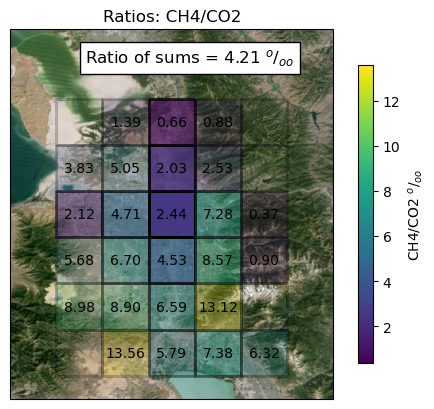

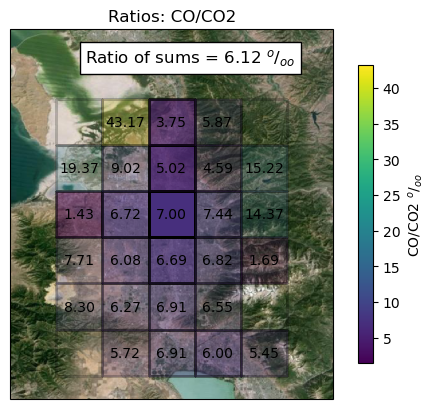

In [137]:
# map_extent={'lon_min':-112.4,
#             'lon_max':-111.4,
#             'lat_min':40.1,
#             'lat_max':41.3} 


ratio_ids = list(ratio_details.keys())
for ratio_id in ratio_ids:
    if ratio_id == 'CH4/CO':
        continue
    da = csl_ds[ratio_id]
    if ratio_id.split('/')[1] == 'CO2':
        alphas = csl_ds['CO2'].values
        alphas = (alphas - alphas.min())/(alphas.max()-alphas.min())*(1-0.2)+0.2
    if ratio_id.split('/')[1] == 'CO':
        alphas = csl_ds['CO'].values
        alphas = (alphas - alphas.min())/(alphas.max()-alphas.min())*(1-0.2)+0.2    
    total_ratio = ratio_details[ratio_id]['tot_ratio']
    permil = ratio_details[ratio_id]['permil']
    if permil:
        da = da*1000
        total_ratio = total_ratio*1000

    map_extent={'lon_low':-112.25,
                'lon_high':-111.55,
                'lat_low':40.3,
                'lat_high':41.1} 
    labsize = 12
    proj = ccrs.PlateCarree()
    fig = plt.figure()
    ax = plt.axes(projection = proj)
    ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
    request = cimgt.GoogleTiles(style='satellite')
    scale = 10.0 # prob have to adjust this
    ax.add_image(request,int(scale))

    map = da.plot.pcolormesh('lon','lat',ax = ax,alpha=alphas,cmap='viridis',add_colorbar=False,edgecolors = 'black')#,vmin=0,vmax = 10)
    colorbar_label = ratio_id
    if permil:
        colorbar_label = ratio_id+" $^o/_{oo}$"
    plt.colorbar(map,fraction=0.03,label = colorbar_label)

    for lat in da.lat.values:
        for lon in da.lon.values:
            value = da.sel(lat=lat,lon=lon).values
            if value != value:
                continue
            plt.text(lon,lat,f'{value:.2f}',color='k',ha='center',va='center')



    text = f"Ratio of sums = {total_ratio:.2f}"
    if permil:
        text = text+ " $^o/_{oo}$"
    t1 = fig.text(0.45,0.81,text,fontsize = labsize)
    t1.set_bbox(dict(facecolor = 'white'))
    plt.title(f"Ratios: {ratio_id}")
    plt.show()

## Month

In [138]:
combined_dss = {}
combined_dss['area'] = xr.open_dataset('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/NC/slc_2019_em27_area.nc')
combined_dss['point'] = xr.open_dataset('/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/NC/slc_2019_em27_point.nc')


In [183]:
dataset_extent = {'lon_min':-112.25,
                  'lon_max':-111.6,
                  'lat_min':40.3,
                  'lat_max':41.1} 
regridded_path = '/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded'
RCH = ncf.Regridded_CSL_Handler(regridded_path)
year = 2019
total_ds_spec = {}
species_all = ['HC01','CO','CO2']
for species in species_all:
    season_summed_ds_dict = {}
    sector_types = ['area','point'] #want to loop through both area and point sources
    for sectors in sector_types:
        ds_combined = combined_dss[sectors]
        mass_unit = ds_combined[species].attrs['units'].split()[0] #this will either be metric_Ton or moles depending on the species chosen

        # # sum on utc_hour and sector first -- can sum on utc hour because the units 
        # # are in "per hour", so this should be "per day" as the new unit indicates
        ds = ds_combined.sel(utc_hour=[14,15,16,17,18,19,20,21,22,23,0,1])
        ds = ds_combined.sum(dim=['utc_hour','sector'])[species].assign_attrs({'units':f'{mass_unit} day^-1 meters^-2'}) 

        #now sum on the months, one by one
        month_sums = []  #initialize the months lists so we can recombine them
        for yr_mo in ds.yr_mo.values: #loop through the months
            if yr_mo not in ['2019-12','2019-1','2019-2']:
                continue
            # if yr_mo not in ['2019-12','2019-1','2019-2']:
            #     continue
            yr = int(yr_mo.split('-')[0]) #get the year int
            mo = int(yr_mo.split('-')[1]) #get the mnoth int
            sat,sun,wkdy = ncf.ncount_satsunwkd(yr,mo) #for that year and month, get the number of saturdays, sundays, and weekdays

            #for each daytype, multiply the values for that day type by the number of that type of days in that month
            sat_sum = (ds.sel(yr_mo=yr_mo,day_type='satdy')*sat).assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
            sun_sum = (ds.sel(yr_mo=yr_mo,day_type='sundy')*sun).assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
            wkdy_sum = (ds.sel(yr_mo=yr_mo,day_type='weekdy')*wkdy).assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})

            #this is the sum of the month --
            #first combine on day_type -- this causes the daytypes to be represented as variables
            #then sum on the variables, and drop the daytype variables, and reassign the units
            month_sum = xr.combine_by_coords([sat_sum.to_dataset(name='sat'),
                                            sun_sum.to_dataset(name='sun'),
                                            wkdy_sum.to_dataset(name='wkdy')
                                            ],compat='override').to_array().sum("variable").drop_vars('day_type').assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
            
            month_sums.append(month_sum.to_dataset(name=yr_mo)) # append each month sum to the list so we can rejoin them

        # #now get the yearsum by combining on the month sums and doing a similar process to above (summing on variables and dropping)
        season_sum = xr.combine_by_coords(month_sums,compat='override').to_array().sum("variable").drop_vars('yr_mo').assign_attrs({'units':f'{mass_unit} meters^-2'})

        if sectors == 'area':
            #the yearsum for area sources is in flux units (per m2), so we need to multiply by grid area to get absolute units per grid cell
            grid_area = xr.open_dataset('/uufs/chpc.utah.edu/common/home/u0890904/NOAA_CSL/noaa_csl/regridding/grid_area/grid_out_area.nc')  #load the gridcell area file
            grid_area = ncf.slice_extent(grid_area,dataset_extent) #slice it to the same extent
            absolute_emissions = (season_sum * grid_area['cell_area']).assign_attrs({'units':mass_unit}) #multiply by the yearsum
        elif sectors == 'point':
            #the yearsum for point sources are already "absolute"
            absolute_emissions = season_sum.to_dataset(name=species)
        season_summed_ds_dict[sectors] = absolute_emissions #append the yearsummed dataset to our holding dictionary

    point_df = season_summed_ds_dict['point'][species].to_dataframe() #create a dataframe from the point data, makes it easier 
    area_ds = season_summed_ds_dict['area'].load() #load the area dataset -- until now it is just represented in xarray, not in memory

    #below is where we aggregate the point dataframe into the same grid as the area dataset by summing all of the point sources
    #within each of the gridcells that are defined in the area_ds
    point_ds = ncf.pointdf_to_ds(point_df,area_ds)  

    total_ds = area_ds + point_ds #add them together 

    if (mass_unit == 'mole') & (species == 'HC01'): #if it's in moles, we want to transform to tonnes so we can compare with EDGAR/EPA etc
        total_ds = total_ds*16.04/1E6 #moles * 16.04 g CH4/ mol * 1E-6 ton/gram
    
    total_ds_spec[species] =total_ds


In [184]:
csl_ds_big = xr.combine_by_coords(total_ds_spec.values())

dataset_extent = {'lon_min':-112.15,
                  'lon_max':-111.7,
                  'lat_min':40.4,
                  'lat_max':41.0} 
csl_ds = ncf.slice_extent(csl_ds_big,dataset_extent)

In [185]:
molar_masses = {'HC01':16.04,'CO2':44.01,'CO':28.01}
ratio_details = {'CH4/CO2':{'specs':['HC01','CO2'],'permil':True},
             'CH4/CO':{'specs':['HC01','CO'],'permil':False},
             'CO/CO2':{'specs':['CO','CO2'],'permil':True}}
quantile = 0.1

In [186]:
for ratio_id in ratio_details.keys():
    specs = ratio_details[ratio_id]['specs']
    numerator_spec = specs[0]
    denominator_spec = specs[1]
    tot_num = float(csl_ds[f'{numerator_spec}'].sum())
    tot_den = float(csl_ds[f'{denominator_spec}'].sum())
    ratio_details[ratio_id]['tot_ratio'] = tot_num/tot_den * molar_masses[denominator_spec]/molar_masses[numerator_spec]
    above_quantile_ds_numerator = csl_ds[numerator_spec].where(csl_ds[numerator_spec]>csl_ds[numerator_spec].quantile(quantile))
    above_quantile_ds_denominator = csl_ds[denominator_spec].where(csl_ds[denominator_spec]>csl_ds[denominator_spec].quantile(quantile))

    csl_ds[ratio_id] = above_quantile_ds_numerator/above_quantile_ds_denominator * molar_masses[denominator_spec]/molar_masses[numerator_spec]

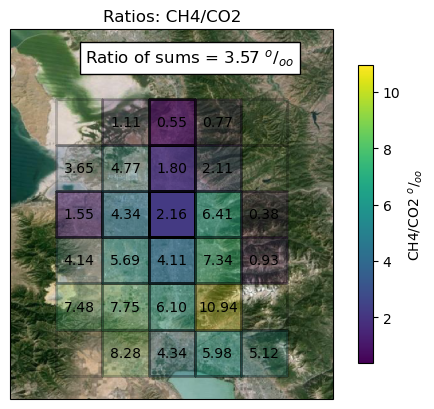

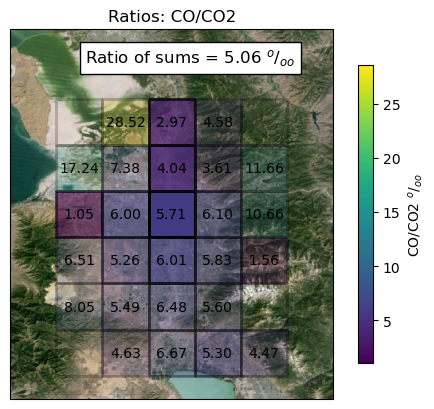

In [187]:
# map_extent={'lon_min':-112.4,
#             'lon_max':-111.4,
#             'lat_min':40.1,
#             'lat_max':41.3} 


ratio_ids = list(ratio_details.keys())
for ratio_id in ratio_ids:
    if ratio_id == 'CH4/CO':
        continue
    da = csl_ds[ratio_id]
    if ratio_id.split('/')[1] == 'CO2':
        alphas = csl_ds['CO2'].values
        alphas = (alphas - alphas.min())/(alphas.max()-alphas.min())*(1-0.2)+0.2
    if ratio_id.split('/')[1] == 'CO':
        alphas = csl_ds['CO'].values
        alphas = (alphas - alphas.min())/(alphas.max()-alphas.min())*(1-0.2)+0.2    
    total_ratio = ratio_details[ratio_id]['tot_ratio']
    permil = ratio_details[ratio_id]['permil']
    if permil:
        da = da*1000
        total_ratio = total_ratio*1000

    map_extent={'lon_low':-112.25,
                'lon_high':-111.55,
                'lat_low':40.3,
                'lat_high':41.1} 
    labsize = 12
    proj = ccrs.PlateCarree()
    fig = plt.figure()
    ax = plt.axes(projection = proj)
    ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
    request = cimgt.GoogleTiles(style='satellite')
    scale = 10.0 # prob have to adjust this
    ax.add_image(request,int(scale))

    map = da.plot.pcolormesh('lon','lat',ax = ax,alpha=alphas,cmap='viridis',add_colorbar=False,edgecolors = 'black')#,vmin=0,vmax = 10)
    colorbar_label = ratio_id
    if permil:
        colorbar_label = ratio_id+" $^o/_{oo}$"
    plt.colorbar(map,fraction=0.03,label = colorbar_label)

    for lat in da.lat.values:
        for lon in da.lon.values:
            value = da.sel(lat=lat,lon=lon).values
            if value != value:
                continue
            plt.text(lon,lat,f'{value:.2f}',color='k',ha='center',va='center')



    text = f"Ratio of sums = {total_ratio:.2f}"
    if permil:
        text = text+ " $^o/_{oo}$"
    t1 = fig.text(0.45,0.81,text,fontsize = labsize)
    t1.set_bbox(dict(facecolor = 'white'))
    plt.title(f"Ratios: {ratio_id}")
    plt.show()